# Proyecto Final Data Science - Interconnect

Para este proyecto nuestra tarea es crear un modelo que logre predecir correctamente cuando un usuario de la base de datos que tenemos de Telecom va a dejar la compañia, para esto se realizara inicialmente un analisis exploratorio de los datos que se tienen, esto incluye carga y exploracion de cada archivo de datos disponible, verificar la estructura de cada archivo e indentificar valores nulos o duplicados, asi como analizar los tipos de datos de cada variable. Tambien se debera unificar los datos en un solo datset y se van a preparar los datos para posteriormente realizar el entrenamiento del modelo. Una vez realizado este procedimiento se procedera con el entrenamiento de modelos basicos para ver cuales dan mejores resultados y una ves identificados se hara un ajuste de hipérparametros para los mejores modelos para obtener un modelo acorde a nuestras necesidades. Al final se presentara los resultados y el modelo obtenidos.

## Plan de trabajo

En esta seccion vamos a plantear un plan de trabajo para el proyecto completo que se ira realizando paso a paso.

1. Limpieza e integración de los datos

En esta seccion nos concentraremos en leer cada set de datos de los que disponemos y darles un tratamiento basico, revisar cuantos datos y que variables tiene cada set, unificar el formato de los nombres, revisar los tipos de datos, que variables catgoricas o numericas se tienen, checar valores nulos o duplicados y revisar valores atipicos.

2. Preparacion de datos y analisis exploratorio

Aqui vamos a terminar de preparar los datos, debemos juntar todos los dataset evitando nuevamente los valores nulos, con los datos juntos y limpios se puede hacer algunas graficas interesantes para sacar informacion util de los datos, una vez hecho esto para terminar la preparacion de los datos para el modelado tambien debemos codificar las columnas categoricas, tenemos varias columnas binarias Yes/No que tambien debemos tratar para poder usar en el modelo, realizar el train test split, lidiar con el desbalance de los datos si es necesario y estandarizar las columnas numericas, con esto hecho ya podemos pasar al entrenamiento de modelos.

3. Entrenamiento de modelos y seleccion de metricas

Para esta parte se propone entrenar varios modelos, comenzando con una regresión logística como línea base y comparándola con modelos más avanzados como LightGBM, Random Forest y XGBoost. Si la variable objetivo está desbalanceada, se aplicará una técnica de sobre-muestreo como Random Oversampling para mejorar la capacidad del modelo de detectar correctamente casos de churn. Se usara como metrica principal la métrica AUC-ROC, ya que es robusta ante desbalance de clases y mide la capacidad del modelo para distinguir entre clases. También se evaluara accuracy para obtener una visión complementaria del desempeño.
Dependiendo del desempeño que presenten los modelos iniciales se hara un ajuste de hiperparametros con GridSearchCV o RandomizedSearchCV para encontrar modelos mas eficases.

4. Conclusiones y reporte final

Una vez seleccionado el modelo se incluirán gráficos como curvas ROC y matrices de confusión para ilustrar visualmente los resultados y facilitar la interpretación. En esta etapa también se analizará la importancia de las variables en modelos basados en árboles para entender mejor los factores que influyen en la pérdida de clientes. Se realizara una entrega final del modelo que se obtuvo y se daran conclusiones y pasos a seguir basados en los resultados encontrados.

## Analisis Exploratorio de Datos

En esta párte nos centraremos en el analisis exploratorio y limpieza de los datos, comencemos por cargar todos los archivos que tenemos disponibles y dar un primer vistazo a todos ellos, contamos con 4 archios de datos que son:

 - contract.csv
 - internet.csv
 - personal.csv
 - phone.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (precision_score, recall_score, f1_score,  confusion_matrix)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from lightgbm import early_stopping, log_evaluation

### Lectura de datos y vista inicial

#### contract

Empezamos con la lectura de contract.csv

In [2]:
contractdf = pd.read_csv("contract.csv")
print (contractdf.shape)
print (contractdf.columns)

(7043, 8)
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [3]:
contractdf.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Vemos a primera vista que hay columnas categoricas, numericas y de fechas, algunas de las categoricas estan distribuidas en Yes/No pero otras tienen distintas categorias, tambien tenemos tambien un formato en las fechas que debemos cambiar.

Tambien podemos cambiar los nombres de las variables para no tener problemas luego.

Algo importante que se debe realizar aqui es la creacion de una variable objetivo, teniendo en cuenta los usuarios que tienen un end date se puede crear una columna con los usuarios que si han dejado la compañia para luego usarla en la creacion del modelo, esta variable sera creada mas adelante.


In [4]:
# funcion para pasar los nombres a formato snake_case
def convertir_a_snake_case(df):
    def a_snake(texto):
        texto = re.sub(r'[\s\-]+', '_', texto)             # Reemplaza espacios y guiones por guiones bajos
        texto = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', texto)  # Separa camelCase o PascalCase
        texto = re.sub(r'__+', '_', texto)                 # Evita dobles guiones bajos
        return texto.strip('_').lower()                    # Elimina guiones bajos iniciales/finales y convierte a minúsculas

    df.columns = [a_snake(col) for col in df.columns]
    return df

In [5]:
contractdf = convertir_a_snake_case(contractdf)
contractdf.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Veamos los tipos de datos:

cambiar yes no por 0 1 hacer una columna objetivo para poder predecir enddate= no, fechas formato, categoricas

In [6]:
contractdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Aqui podemos ver que los formatos de algunas variables estan incorrectos, las columnas de fecha tienen formato object, este se cambiara a datetime, ademas la variable total_charges deberia ser numerica.

Cambiemos la columna a numerica

In [7]:
# Convertir TotalCharges a float, manejando errores
contractdf["total_charges"] = pd.to_numeric(contractdf["total_charges"], errors='coerce')
contractdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Se añadieron algunos valores nulos a la columna total charges, vemos que datos son:

In [8]:
contractdf[contractdf["total_charges"].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


los datos nulos son de clientes que apenas entraron a la compañia por lo que en este caso el valor de total charges sera igual al valor de un mes, en este caso lo tomaremos de la columna de monthly charges.

In [9]:
#llenar datos nulos de la columna total charges usando el cargo mensual para los que solo llevan 1 mes
contractdf["total_charges"] = contractdf["total_charges"].fillna(contractdf["monthly_charges"])
contractdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Ahora hagamos el cambio de las columnas de fechas

In [10]:
# Convertir fechas a tipo datetime
contractdf["begin_date"] = pd.to_datetime(contractdf["begin_date"])
contractdf["end_date"] = pd.to_datetime(contractdf["end_date"], errors='coerce')  # Manejar valores "No"
print (contractdf.info())
print("Valores nulos por columna contractdf:\n", contractdf.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None
Valores nulos por columna contractdf:
 customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
dtype: int64


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17892\2709934275.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contractdf["end_date"] = pd.to_datetime(contractdf["end_date"], errors='coerce')  # Manejar valores "No"


Cambiar la columna end_date a formato fecha añade algunos valores nulos (5174) para los clientes que siguen en la compañia y por lo tanto no tienen fecha de salida, esto se usara para la creacion de la variable churn.

In [11]:
# Crear variable Churn (1 si el cliente canceló, 0 si sigue activo)
contractdf["churn"] = contractdf["end_date"].notna().astype(int)
contractdf.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [12]:
contractdf.duplicated().sum()

0

In [13]:
contractdf.describe(include="all")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
count,7043,7043,1869,7043,7043,7043,7043.000000,7043.000000,7043.000000
unique,7043,NaN,NaN,3,2,4,NaN,NaN,NaN
top,7590-VHVEG,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,1,NaN,NaN,3875,4171,2365,NaN,NaN,NaN
mean,NaN,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630976,NaN,NaN,NaN,64.761692,2279.798992,0.265370
min,NaN,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,18.250000,18.800000,0.000000
25%,NaN,2015-06-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,35.500000,398.550000,0.000000
50%,NaN,2017-09-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,70.350000,1394.550000,0.000000
75%,NaN,2019-04-01 00:00:00,2019-12-01 00:00:00,NaN,NaN,NaN,89.850000,3786.600000,1.000000
max,NaN,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,118.750000,8684.800000,1.000000


Seria interesante ver los porcentajes de las variables categoricas

In [14]:
def calcular_porcentajes_por_columna(df, excluir=None):
    """
    Calcula el porcentaje de cada valor único por columna.
    
    Argumentos:
        df (DataFrame): El DataFrame de entrada.
        excluir (lista): Lista de nombres de columnas a excluir (opcional).
        
    Retorna:
        dict: Diccionario con Series de porcentajes por columna.
    """
    if excluir is None:
        excluir = []

    resultado = {}
    for col in df.columns:
        if col not in excluir:
            porcentaje = (df[col].value_counts(normalize=True, dropna=False) * 100).round(2)
            resultado[col] = porcentaje

    for col, dist in resultado.items():
        print(f"\n📊 {col}")
        print(dist)

    return 

In [15]:
calcular_porcentajes_por_columna(contractdf, excluir=["customer_id", "begin_date", "end_date", "monthly_charges", "total_charges"])


📊 type
type
Month-to-month    55.02
Two year          24.07
One year          20.91
Name: proportion, dtype: float64

📊 paperless_billing
paperless_billing
Yes    59.22
No     40.78
Name: proportion, dtype: float64

📊 payment_method
payment_method
Electronic check             33.58
Mailed check                 22.89
Bank transfer (automatic)    21.92
Credit card (automatic)      21.61
Name: proportion, dtype: float64

📊 churn
churn
0    73.46
1    26.54
Name: proportion, dtype: float64


De aqui podemos concluir varias cosas:

 - no parece haber customer_id repetidos
 - hay tres tipos de contrato, por lo que hemos visto hasta ahora son mes a mes, de un año y de dos años, donde mes a mes es el mas frecuente
 - hay una cantidad similar de personas que prefieren paperles billing de las que no
 - hay 4 tipos de metodo de pago, tarjeta, cheque electronico, cheque fisico y transferencia automatica
 - la variable monthly charges no parece tener valores atipicos ya que la media y la mediana son bastante cercanas, el valor maximo difiere de la mediana aproximadamente en dos std por lo que no es tan inusual
 - la variable total charges tiene una ligera diferencia entre la mediana y la media pero no es mas de una desviacion estandar, haremos un grafico para verificar si hay valores que deban ser tratados
 - Estamos ante un problema de clases desbalanceadas ya que la clase 1 de la variable churn tiene mucho menor porcentaje que la clase 0

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


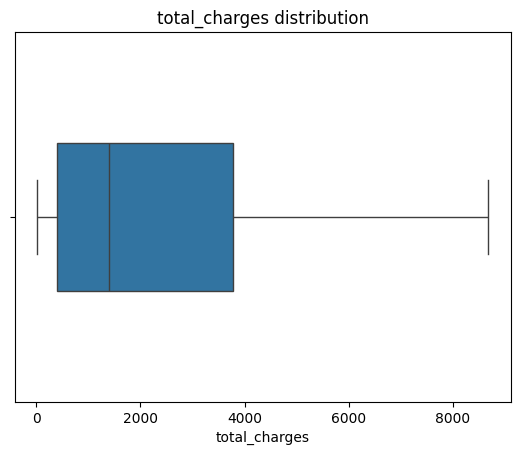

In [16]:
# Boxplot variable total charges
sns.boxplot(
    x=contractdf["total_charges"],
    width=0.4,
    fliersize=6,        # tamaño de los puntos atípicos
    flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"}
)
plt.title("total_charges distribution")
plt.show()

Por ahora eso es lo que necesitamos para este dataframe, pasemos al siguiente.

#### internet

Ahora vamos con el df internet.csv

In [17]:
internetdf = pd.read_csv("internet.csv")
print (internetdf.shape)
print (internetdf.columns)

(5517, 8)
Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')


Tenemos menos datos que en el anterior lo que sugiere que no todos los clientes usan servicios de internet, en este dataframe tambien se incluyen datos de servicios de streaming como StreamingTV y StreamingMovies

Ya que en un futuro se uniran todos los dataset, es util la creacion de una nueva columna que nos indique especificamente que tipo de servicios usan los clientes, por eso vamos a crear una variable internet, que nos permita identificar a todos los usuarios que usan internet de los demas.

In [18]:
internetdf["internet"]=1.
internetdf["internet"] = internetdf["internet"].astype(int)

In [19]:
internetdf.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,1
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,1
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,1


Aqui no tenemos columnas numericas, solamente parece haber columnas categoricas, la mayoria de ellas son de Yes/No que convertiremos mas adelante a 1/0 y hay tambien columnas con mas categorias que en este caso solo parece ser InternetService, arreglemos los nombres de las variables a formato snake_case

In [20]:
internetdf = convertir_a_snake_case(internetdf)
internetdf.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'internet'],
      dtype='object')

In [21]:
#info
internetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
 8   internet           5517 non-null   int32 
dtypes: int32(1), object(8)
memory usage: 366.5+ KB


No hay datos faltantes en este df y los tipos de datos parecen estar todos correctos para variables categoricas

In [22]:
internetdf.duplicated().sum()

0

In [23]:
#describe
internetdf.describe(include="all")

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet
count,5517,5517,5517,5517,5517,5517,5517,5517,5517.0
unique,5517,2,2,2,2,2,2,2,NaN
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No,NaN
freq,1,3096,3498,3088,3095,3473,2810,2785,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [24]:
calcular_porcentajes_por_columna(internetdf, excluir=["customer_id"])


📊 internet_service
internet_service
Fiber optic    56.12
DSL            43.88
Name: proportion, dtype: float64

📊 online_security
online_security
No     63.4
Yes    36.6
Name: proportion, dtype: float64

📊 online_backup
online_backup
No     55.97
Yes    44.03
Name: proportion, dtype: float64

📊 device_protection
device_protection
No     56.1
Yes    43.9
Name: proportion, dtype: float64

📊 tech_support
tech_support
No     62.95
Yes    37.05
Name: proportion, dtype: float64

📊 streaming_tv
streaming_tv
No     50.93
Yes    49.07
Name: proportion, dtype: float64

📊 streaming_movies
streaming_movies
No     50.48
Yes    49.52
Name: proportion, dtype: float64

📊 internet
internet
1    100.0
Name: proportion, dtype: float64


- nuevamente no tenemos customer_id repetidos
- el tipo de servicio mas usado es la fibra optica pero el porcentaje no es mucho mayor que el de DSL

Pasemos al siguiente df

#### personal

Veamos ahora los datos del archivo personal.csv

In [25]:
personaldf = pd.read_csv("personal.csv")
print (personaldf.shape)
print (personaldf.columns)

(7043, 5)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')


Tenemos el mismo numero de datos que en contractdf, aqui hay informacion personal de los usuarios como si son personas de edad, si tienen pareja, su genero y si tienen personas a cargo.

In [26]:
personaldf.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Todas las variables son categoricas, estan 2 de ellas estan en terminos de Yes/No, una esta ya en terminos de 1/0, y el genero esta en Male/Female, todas las que no estan en 1/0 deberan ser convertidas despues a estos terminos para poderse usar en el modelo.

In [27]:
personaldf = convertir_a_snake_case(personaldf)
personaldf.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [28]:
#info
personaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


No tenemos valores nulos en este df y los tipos de datos estan correctos por ahora.

In [29]:
personaldf.duplicated().sum()

0

In [30]:
#describe
personaldf.describe(include="all")

,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


- No tenemos customer_id repetidos
- al parecer tenemos una cantidad de datos igual de hombres y mujeres, es decir aproximadamente la mitad de los datos son de hombre y la otra mitad de mujeres
- lo mismo sucede con las personas que tienen o no pareja, al parecer aproximadamente la mitad de las personas tienen pareja y la otra mitad no
- Hay mas gente que tiene personas que dependen de ellos que gente que no tiene a ningun dependiente

veamos los porcentajes de cada variable:

In [31]:
calcular_porcentajes_por_columna(personaldf, excluir=["customer_id"])


📊 gender
gender
Male      50.48
Female    49.52
Name: proportion, dtype: float64

📊 senior_citizen
senior_citizen
0    83.79
1    16.21
Name: proportion, dtype: float64

📊 partner
partner
No     51.7
Yes    48.3
Name: proportion, dtype: float64

📊 dependents
dependents
No     70.04
Yes    29.96
Name: proportion, dtype: float64


Por ultimo el archivo phone.csv

#### phone

Por ultimo veamos este dataset

In [32]:
phonedf = pd.read_csv("phone.csv")
print (phonedf.shape)
print (phonedf.columns)

(6361, 2)
Index(['customerID', 'MultipleLines'], dtype='object')


Solo tenemos datos de customer_id y de si el usuario tiene mas de una linea, asumimos que si el customer_id se encuentra en este dataframe es porque tiene un plan de celular, por lo que seria interesante crear una columna phone services para todo los usuarios en este dataset y poder ubicarlos una ves se unan los archivos

In [33]:
phonedf["Phone"]=1.
phonedf["Phone"] = phonedf["Phone"].astype(int)
phonedf.head()

,customerID,MultipleLines,Phone
0,5575-GNVDE,No,1
1,3668-QPYBK,No,1
2,9237-HQITU,No,1
3,9305-CDSKC,Yes,1
4,1452-KIOVK,Yes,1


multiple_lines y phone son categoricas, multiple lines aun se encuentra en terminos de Yes/No por lo que habra que hacer el cambio mas adelante.

In [34]:
phonedf = convertir_a_snake_case(phonedf)
phonedf.columns

Index(['customer_id', 'multiple_lines', 'phone'], dtype='object')

In [35]:
phonedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
 2   phone           6361 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 124.4+ KB


In [36]:
phonedf.duplicated().sum()

0

In [37]:
phonedf.describe(include="all")

,customer_id,multiple_lines,phone
count,6361,6361,6361.0
unique,6361,2,NaN
top,5575-GNVDE,No,NaN
freq,1,3390,NaN
mean,NaN,NaN,1.0
std,NaN,NaN,0.0
min,NaN,NaN,1.0
25%,NaN,NaN,1.0
50%,NaN,NaN,1.0
75%,NaN,NaN,1.0


In [38]:
calcular_porcentajes_por_columna(phonedf, excluir=["customer_id"])


📊 multiple_lines
multiple_lines
No     53.29
Yes    46.71
Name: proportion, dtype: float64

📊 phone
phone
1    100.0
Name: proportion, dtype: float64


### Preparacion Datos y EDA

En esta parte del proyecto tenemos varias cosas por hacer:
- primero vamos a pasar todas las columnas que estaban en termminos de Yes/No a valores 1/0 para poder usarlas posteriormente para el entrenamiento del modelo
- tambien debemos juntar todos los datos que tenemos en un solo dataframe que usaremos luego
- realizar algunas graficas interesante sobre los datos para entender mejor sus relaciones y obtener informacion importante
- una vez tengamos esa informacion ya podemos codificar las variables categoricas de ser necesario para poderlos usar en el entrenamiento del modelo
- debemos tambien realizar un train test split para poder entrenar el modelo y tecnicas de oversampling para lidiar con el desbalance de clases
- una vez terminemos con esto los datos deberian estar listos para probar algunos modelos

#### Conversion de columnas binarias

Empezemos por pasar todas las columnas de Yes/No a 1/0, para esto haremos una funcion y la usaremos en cada dataset en las columnas correspondientes

In [39]:
# Convertir variables categóricas binarias Yes/No a 1/0
def binary_conversion(df, columns):
    for col in columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0}).astype(int)
    return df

Ahora lo usamos en contractdf:

In [40]:
binary_columns = ["paperless_billing"]
contractdf = binary_conversion(contractdf, binary_columns)
print (contractdf.info())
contractdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int32         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(2), object(3)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


Vemos que la columna ya esta en terminos de 1/0 y es ademas una columna de enteros.

Sigamos con internetdf:

In [41]:
binary_columns = ["online_security", "online_backup", "device_protection", "tech_support", "streaming_tv", "streaming_movies"]
internetdf = binary_conversion(internetdf, binary_columns)
internetdf.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1


Ahora con personaldf:

In [42]:
binary_columns = ["partner", "dependents"]
personaldf = binary_conversion(personaldf, binary_columns)
personaldf.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


por ultimo phonedf:

In [43]:
binary_columns = ["multiple_lines"]
phonedf = binary_conversion(phonedf, binary_columns)
phonedf.head()

,customer_id,multiple_lines,phone
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


Ahora vamos a juntar los dataframe, para poder hacer analisis y graficas despues

#### Juntar los dataframe

En esta seccion vamos a unir todos nuestros dataframe en uno solo que usaremos luego para poder entrenar el modelo, para esto usaremos el customer_id, que es comun a todos los dataframe.

In [44]:
data_merged = contractdf.merge(personaldf, on="customer_id", how="left")
display (data_merged.head(10), data_merged.shape)
print(data_merged.isnull().sum())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,Male,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,Female,0,0,0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,1,Credit card (automatic),89.10,1949.40,0,Male,0,0,1
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,0,Mailed check,29.75,301.90,0,Female,0,0,0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,Female,0,1,0
9,6388-TABGU,2014-12-01,NaT,One year,0,Bank transfer (automatic),56.15,3487.95,0,Male,0,0,1


(7043, 13)

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
dtype: int64


Aun tenemos algunos datos faltantes en las fechas, estos corresponden a los usuarios que aun estan en la compañia y por lo tanto no tienen fecha de finalizacion del contrato, estas columnas de fecha no pueden ser usadas en el entrenamiento del modelo, por lo tanto se eliminaran eventualmente del dataframe final, pero aun tienen informacion que podria ser util sobre el mes o año en que los usuarios dejaron la compañia asi que aun no se van a eliminar, veremos esta informacion mas adelante en la seccion de graficos.

Ahora vamos a unir el siguiente df, internetdf:

In [45]:
data_merged = data_merged.merge(internetdf, on="customer_id", how="left")
display (data_merged.head(10), data_merged.shape)
print(data_merged.isnull().sum())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,Male,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,Female,...,0,0,Fiber optic,0.0,0.0,1.0,0.0,1.0,1.0,1.0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,1,Credit card (automatic),89.10,1949.40,0,Male,...,0,1,Fiber optic,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,0,Mailed check,29.75,301.90,0,Female,...,0,0,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,Female,...,1,0,Fiber optic,0.0,0.0,1.0,1.0,1.0,1.0,1.0
9,6388-TABGU,2014-12-01,NaT,One year,0,Bank transfer (automatic),56.15,3487.95,0,Male,...,0,1,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0


(7043, 21)

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
internet             1526
dtype: int64


aqui se introducen algunos valores nulos debido a algunos de los clientes no tienen alguno de los servicios mencionados arriba, para la columna internet service, que dice que tipo de servicio de internet tienen se llenara con None, ya que estos usuarios no tienen ningun tipo de servicio de internet, para las demas columnas relacionadas con internet se llenara con 0.

In [46]:
data_merged["internet_service"] = data_merged["internet_service"].fillna("None")
print(data_merged.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
internet             1526
dtype: int64


Ahora llenamos con 0 el resto de columnas:

In [47]:
columns_to_fill = ["online_security", "online_backup", "device_protection", "tech_support", "streaming_tv", "streaming_movies", "internet"]
for col in columns_to_fill:
    data_merged[col] = data_merged[col].fillna(0)
    data_merged[col] = data_merged[col].astype(int)
print(data_merged.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
internet                0
dtype: int64


y vamos con el ultimo dataframe, phonedf:

In [48]:
data_merged = data_merged.merge(phonedf, on="customer_id", how="left")
display (data_merged.head(10), data_merged.shape)
print(data_merged.isnull().sum())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,DSL,0,1,0,0,0,0,1,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,Male,...,DSL,1,0,1,0,0,0,1,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,DSL,1,1,0,0,0,0,1,0.0,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,DSL,1,0,1,1,0,0,1,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,Fiber optic,0,0,0,0,0,0,1,0.0,1.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,Female,...,Fiber optic,0,0,1,0,1,1,1,1.0,1.0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,1,Credit card (automatic),89.10,1949.40,0,Male,...,Fiber optic,0,1,0,0,1,0,1,1.0,1.0
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,0,Mailed check,29.75,301.90,0,Female,...,DSL,1,0,0,0,0,0,1,NaN,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,Female,...,Fiber optic,0,0,1,1,1,1,1,1.0,1.0
9,6388-TABGU,2014-12-01,NaT,One year,0,Bank transfer (automatic),56.15,3487.95,0,Male,...,DSL,1,1,0,0,0,0,1,0.0,1.0


(7043, 23)

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
internet                0
multiple_lines        682
phone                 682
dtype: int64


nuevamente aqui se introducen algunos valores nulos de clientes que usan los otros servicios pero no de telefono por lo que estos valore se llenan con 0

In [49]:
columns_to_fill = ["multiple_lines", "phone"]
for col in columns_to_fill:
    data_merged[col] = data_merged[col].fillna(0)
    data_merged[col] = data_merged[col].astype(int)
print(data_merged.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
internet                0
multiple_lines          0
phone                   0
dtype: int64


#### Graficas utiles

##### Distribucion cargos mensuales y totales

Empecemos viendo la distribución de los cargos mensuales y totales

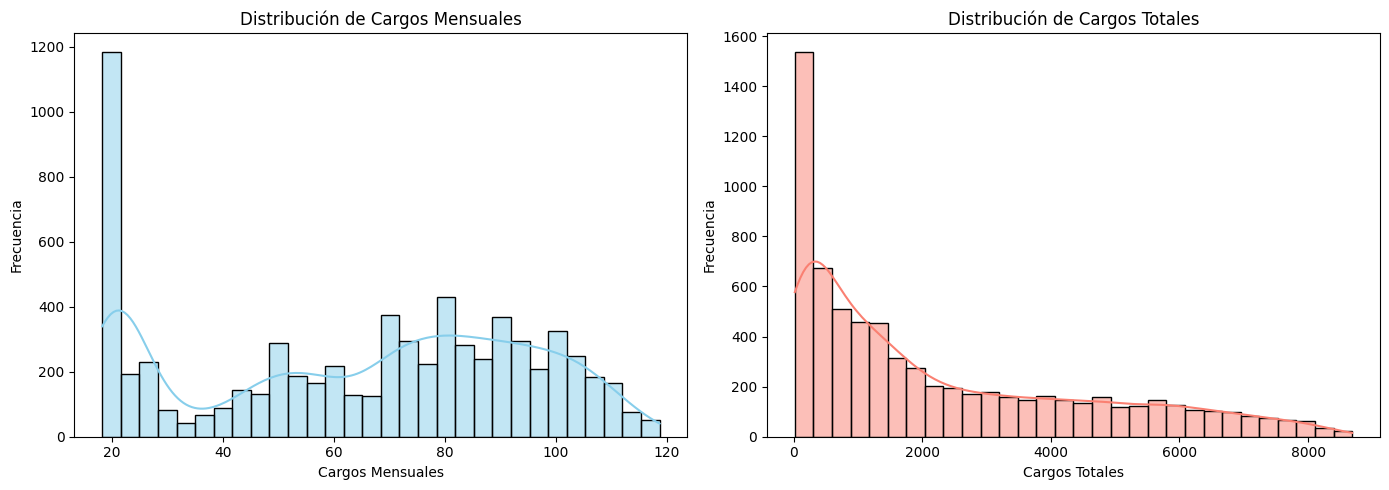

In [50]:
plt.figure(figsize=(14, 5))

# Gráfico 1 - monthly_charges
plt.subplot(1, 2, 1)
sns.histplot(data_merged["monthly_charges"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de Cargos Mensuales")
plt.xlabel("Cargos Mensuales")
plt.ylabel("Frecuencia")

# Gráfico 2 - total_charges (o la variable que quieras comparar)
plt.subplot(1, 2, 2)
sns.histplot(data_merged["total_charges"], bins=30, kde=True, color="salmon")
plt.title("Distribución de Cargos Totales")
plt.xlabel("Cargos Totales")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Estas distribuciones se ven normales, no hay nada extraño en ellas, se puede ver que no hay cargos mensuales muy frecuentes alrededor de 30 - 40 dolares mensuales, puede ser debido a las tarifas de los servicios, se podria tratar de incluir algun plan que entre en ese rango de precio que no incluya los beneficios de los puntos mas costosos.

##### Mes y año

Calculemos el año y mes en que los clientes dejaron la empresa

In [51]:
data_merged["end_year"] = data_merged["end_date"].dt.year
data_merged["end_month"] = data_merged["end_date"].dt.month
#data_merged.head()

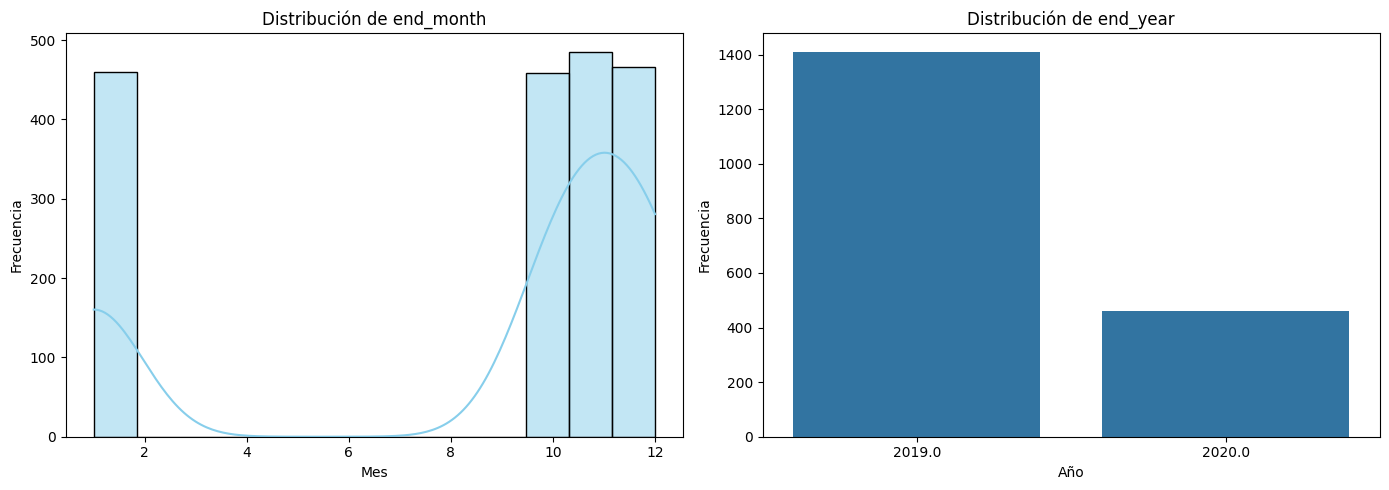

In [52]:
#grafica año mes group by
plt.figure(figsize=(14, 5))

# Gráfico 1 - end month
plt.subplot(1, 2, 1)
sns.histplot(data_merged["end_month"], bins=13, kde=True, color="skyblue")
plt.title("Distribución de end_month")
plt.xlabel("Mes")
plt.ylabel("Frecuencia")

# Gráfico 2 - end year
plt.subplot(1, 2, 2)
sns.countplot(x=data_merged["end_year"])
plt.title("Distribución de end_year")
plt.xlabel("Año")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [53]:
data_merged["end_date"].value_counts()

end_date
2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: count, dtype: int64

Al parecer solo tenemos datos de salida de la empresa para los ultimos meses de 2019 y el primer mes de 2020, hay que preguntar que sucede con los datos faltantes o porque solamente tenemos estos datos.

Veamos tambien una nueva variable que podria ser util, tenure, numero de meses que ha estado un cliente en la compañia

##### Tenure

In [54]:
# Calcular tenure meses de servicio
fecha_referencia = pd.Timestamp("2020-02-01 00:00:00") # fecha maxima
data_merged["tenure"] = ((fecha_referencia - data_merged["begin_date"]).dt.days // 30).fillna(0).astype(int)

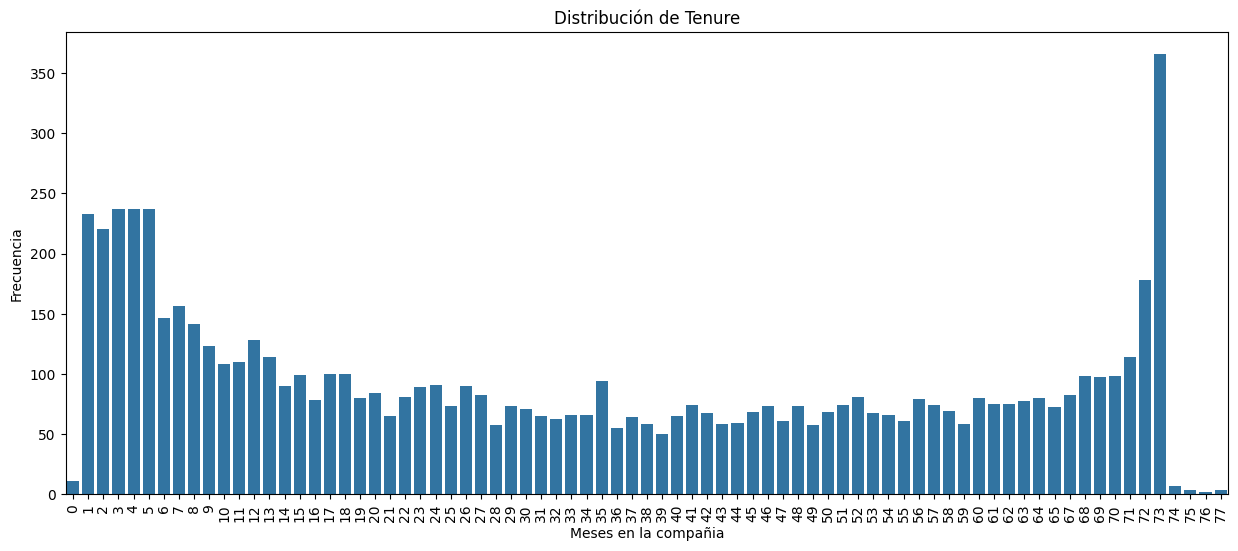

In [55]:
# Análisis de distribución de datos

plt.figure(figsize=(15, 6))
sns.countplot(x = data_merged["tenure"])
plt.title("Distribución de Tenure")
plt.xlabel("Meses en la compañia")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)  # Gira las etiquetas 45 grados
plt.show()


In [56]:
data_merged["tenure"].value_counts(ascending=False)

tenure
73    366
4     237
3     237
5     237
1     233
     ... 
0      11
74      7
77      3
75      3
76      2
Name: count, Length: 77, dtype: int64

Al parecer hay un buen numero de personas que llevan bastante tiempo en la compañia, de hecho es tenure mas comun el de 73 meses (6 años), de ahi el tenure tiene una distribucion estable, se ve un ligero aumento en las personas que llevan pocos meses y luego la distribucion se estabiliza hasta los numeros mas altos.

##### Churn, variable objetivo

Veamos la distribucion de la variable objetivo

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17892\22369618.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_merged, x="churn", palette="pastel")
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


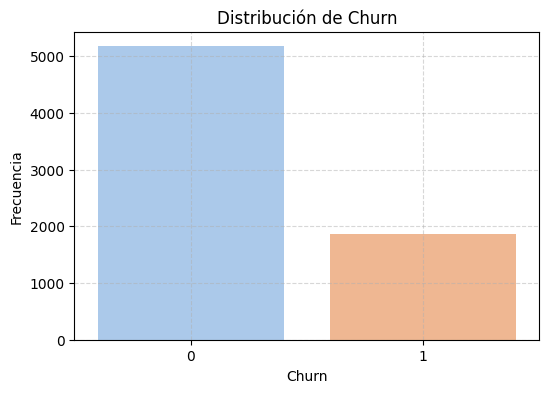

In [57]:
# Distribución de la variable objetivo Churn
plt.figure(figsize=(6, 4))
sns.countplot(data=data_merged, x="churn", palette="pastel")
plt.title("Distribución de Churn")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Churn")
plt.ylabel("Frecuencia")
plt.show()

Como vimos antes estamos ante un problema de desbalance respecto a la variable objetivo, ya que la clase 0 es mucho mas abundante que la clase 1.
Aunque estamos tratando de reducir el numero de personas en la clase 1 de este grafico, que exista esta distribucion es algo que se puede esperar, como veremos a continuacion la forma de este grafico se repite en muchas otras graficas si comparamos churn con otras variables, pero si la forma del grafico cambia, es decir si hay mas gente dejando la compañia respecto a cierta variable podemos saber que puede haber algo ocurriendo con ese servicio o caracteristica que no esta funcionando bien, si el grafico es similar al que vemos aqui se puede considerar un comportamiento normal.

##### Otras variables vs churn

Veamos la relacion de las variables categoricas vs Churn, primero de los servicios generales, phone, internet, streaming_tv, streaming_movies.

In [58]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int32         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int32         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int32         
 12  dependents         7043 non-null   int32         
 13  internet_service   7043 non-null   object        
 14  online_s

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

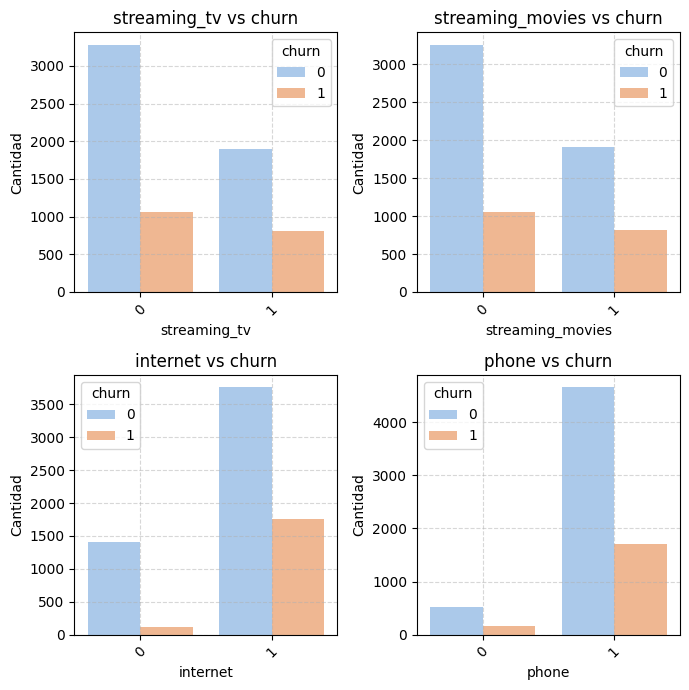

In [59]:
# Lista de las variables categóricas que quieres graficar
variables = ["streaming_tv", "streaming_movies", "internet", "phone"]

# Número total de variables
n = len(variables)

# Definir cuántas columnas tendrá la cuadrícula de subplots
cols = 2

# Calcular el número de filas necesarias según la cantidad de variables
rows = (n + cols - 1) // cols

# Crear la figura con subplots (matriz de ejes)
fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))

# Iterar sobre las variables y sus índices
for i, var in enumerate(variables):
    # Seleccionar el eje correspondiente (fila y columna)
    ax = axes[i // cols, i % cols]
    
    # Crear el gráfico countplot en ese subplot
    sns.countplot(x=data_merged[var], hue=data_merged["churn"], palette="pastel", ax=ax)
    
    # Título y etiquetas para cada gráfico
    ax.set_title(f"{var} vs churn")
    ax.set_xlabel(var)
    ax.set_ylabel("Cantidad")
    
    # Girar las etiquetas del eje X si son largas
    ax.tick_params(axis='x', rotation=45)

    # Añadir la grilla al gráfico
    ax.grid(True, linestyle="--", alpha=0.5)

# Ocultar subplots vacíos (si hay más subplots que variables)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

# Ajustar los espacios para que no se sobrepongan los elementos
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

los graficos de streaming movies y tv son bastante similares, tienen casi el mismo comportamiento, y muy similar al que vimos anteriormente por lo que se puede considerar normal, en cambio internet y phone presentan diferencias respecto a lo que habiamos visto antes.

Vemos que hay mas cancelaciones entre quienes usan servicios de internet y telefono que en quienes no lo hacen lo que podria indicar algun tipo de problema con estos servicios, veamos mas variables relacionadas con estos servicios a ver si obtenemos mas informacion.

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

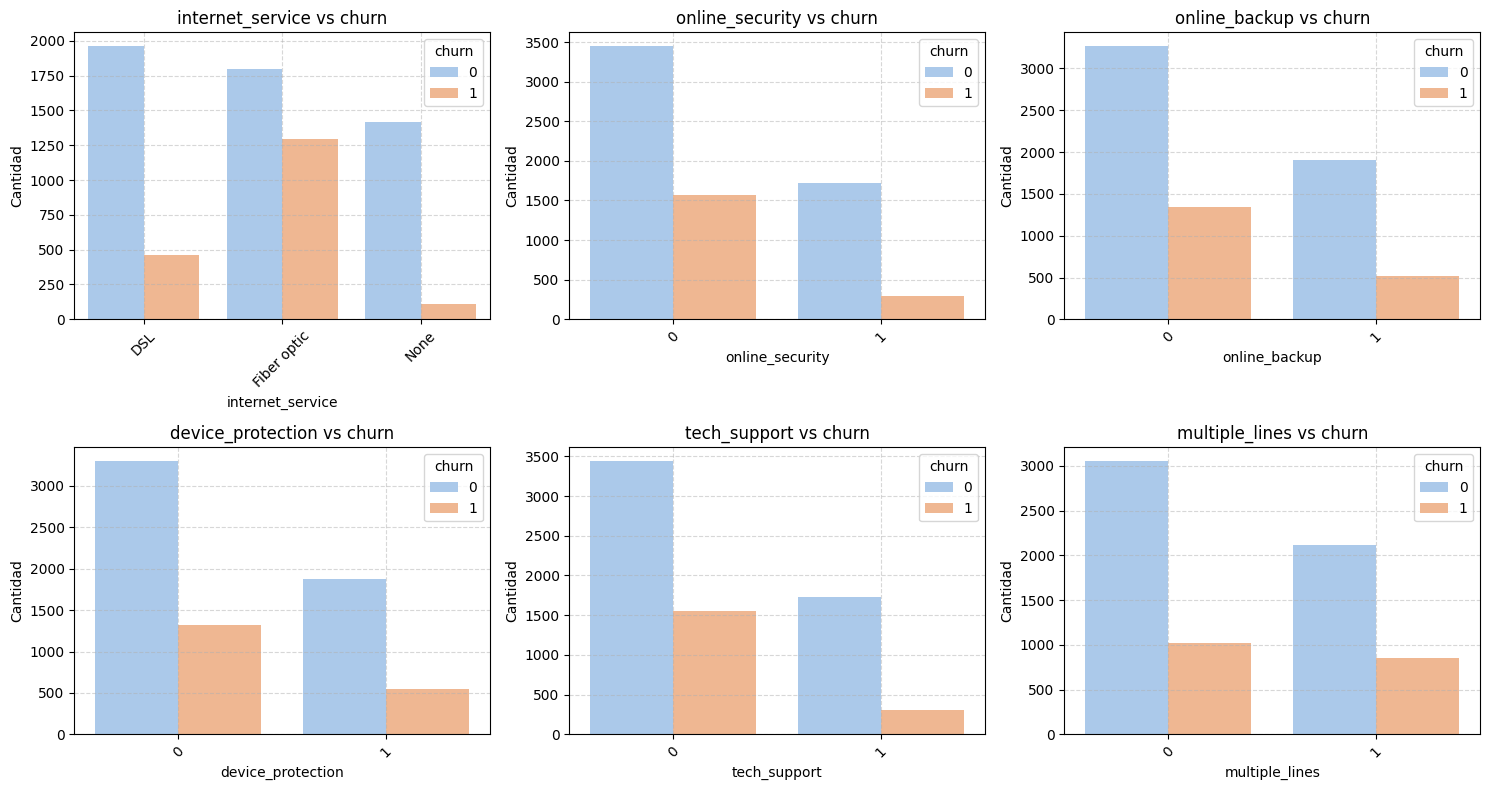

In [60]:
# Lista de las variables categóricas que quieres graficar
variables = ["internet_service", "online_security", "online_backup", "device_protection",
                    "tech_support", "multiple_lines"]

# Número total de variables
n = len(variables)

# Definir cuántas columnas tendrá la cuadrícula de subplots
cols = 3

# Calcular el número de filas necesarias según la cantidad de variables
rows = (n + cols - 1) // cols

# Crear la figura con subplots (matriz de ejes)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Iterar sobre las variables y sus índices
for i, var in enumerate(variables):
    # Seleccionar el eje correspondiente (fila y columna)
    ax = axes[i // cols, i % cols]
    
    # Crear el gráfico countplot en ese subplot
    sns.countplot(x=data_merged[var], hue=data_merged["churn"], palette="pastel", ax=ax)
    
    # Título y etiquetas para cada gráfico
    ax.set_title(f"{var} vs churn")
    ax.set_xlabel(var)
    ax.set_ylabel("Cantidad")
    
    # Girar las etiquetas del eje X si son largas
    ax.tick_params(axis='x', rotation=45)

    # Añadir la grilla al gráfico
    ax.grid(True, linestyle="--", alpha=0.5)

# Ocultar subplots vacíos (si hay más subplots que variables)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

# Ajustar los espacios para que no se sobrepongan los elementos
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

el primer grafico nos da informacion importante, la mayor tasa de cancelacion se encuentra en las personas que usan fibra optica como servicio de internet, y es bastante mayor que los que usan DSL, esto indica que algo respecto de ese servicio esta provocando la salida de clientes.
Se propone revisar la calidad y continuidad del servicio o consultar a los clientes si hay algo que no este funcionando respecto de la fibra optica.

Tambien la tasa de decercion de los clientes que si tienen online_security es bastante baja, se puede pensar en añadir este servicio a algun plan para reducir la desercion.
Lo mismo que con online_security sucede con tech_support.

las otras graficas presentan un comportamiento normal relativo a la desercion en general.

Veamos ahora graficas relacionadas con pagos y facturas:

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

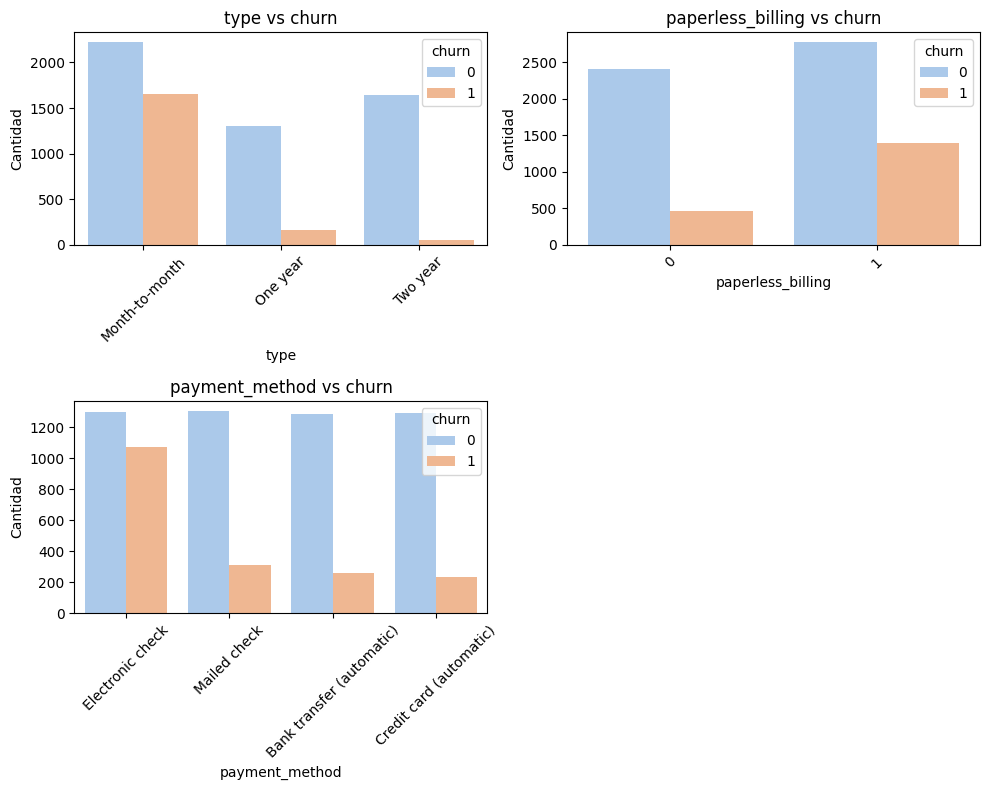

In [61]:
# Lista de las variables categóricas que quieres graficar
variables = ["type", "paperless_billing", "payment_method"] 

# Número total de variables
n = len(variables)

# Definir cuántas columnas tendrá la cuadrícula de subplots
cols = 2

# Calcular el número de filas necesarias según la cantidad de variables
rows = (n + cols - 1) // cols

# Crear la figura con subplots (matriz de ejes)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Iterar sobre las variables y sus índices
for i, var in enumerate(variables):
    # Seleccionar el eje correspondiente (fila y columna)
    ax = axes[i // cols, i % cols]
    
    # Crear el gráfico countplot en ese subplot
    sns.countplot(x=data_merged[var], hue=data_merged["churn"], palette="pastel", ax=ax)
    
    # Título y etiquetas para cada gráfico
    ax.set_title(f"{var} vs churn")
    ax.set_xlabel(var)
    ax.set_ylabel("Cantidad")
    
    # Girar las etiquetas del eje X si son largas
    ax.tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos (si hay más subplots que variables)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

# Ajustar los espacios para que no se sobrepongan los elementos
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

la tasa de desercion de los usuarios que tienen contrato de mes a mes es mucho mayor que la de los que tienen contratos anuales o de dos años, de ser posible, se deberia tratar de ofrecer contratos a mayor tiempo incluso con algun descuento si se quiere reducir la desercion.

el patron de desercion cambia tambien para las personas que optaron por paperles_billing y para las personas que realizan sus pagos a traves de cheques electronicos, se deberia revisar estas caracteristicas para asegurarse de que esten funcionando correctamente.

Finalmente, veamos las variables personales de los clientes:

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

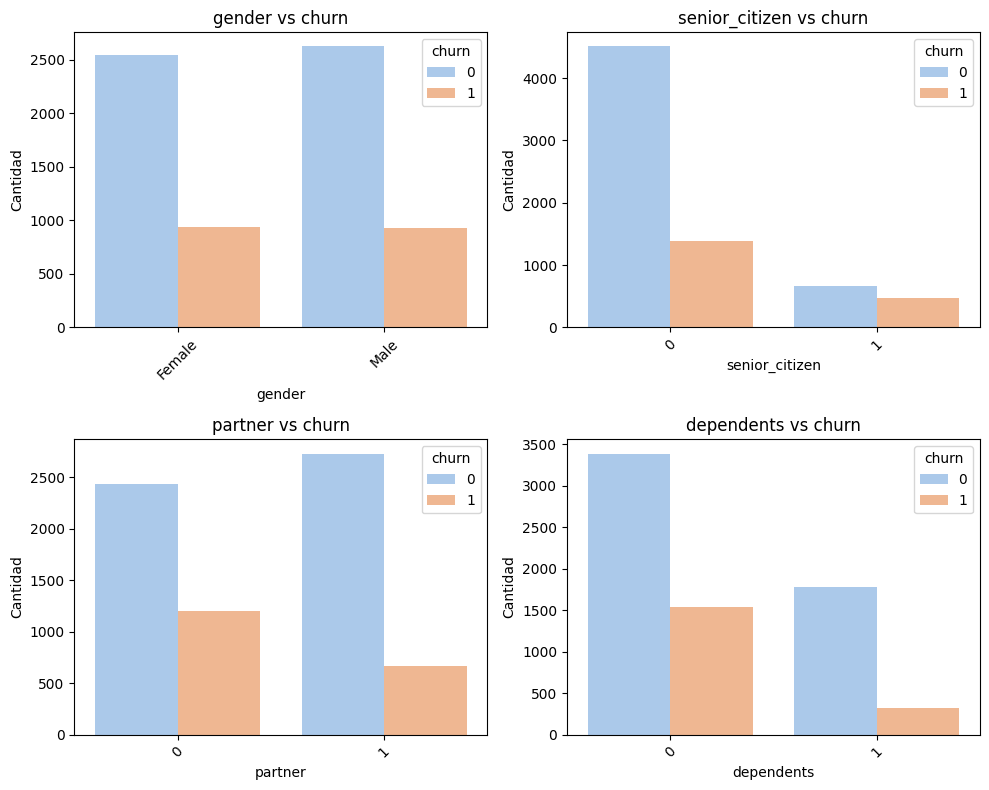

In [62]:
# Lista de las variables categóricas que quieres graficar
variables = ["gender", "senior_citizen", "partner",
                    "dependents"]

# Número total de variables
n = len(variables)

# Definir cuántas columnas tendrá la cuadrícula de subplots
cols = 2

# Calcular el número de filas necesarias según la cantidad de variables
rows = (n + cols - 1) // cols

# Crear la figura con subplots (matriz de ejes)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Iterar sobre las variables y sus índices
for i, var in enumerate(variables):
    # Seleccionar el eje correspondiente (fila y columna)
    ax = axes[i // cols, i % cols]
    
    # Crear el gráfico countplot en ese subplot
    sns.countplot(x=data_merged[var], hue=data_merged["churn"], palette="pastel", ax=ax)
    
    # Título y etiquetas para cada gráfico
    ax.set_title(f"{var} vs churn")
    ax.set_xlabel(var)
    ax.set_ylabel("Cantidad")
    
    # Girar las etiquetas del eje X si son largas
    ax.tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos (si hay más subplots que variables)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

# Ajustar los espacios para que no se sobrepongan los elementos
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

Aqui las graficas presentan una distribucion esperada, con excepcion de los clientes de edad, al parecer muchos de los clientes senior terminan dejando la empresa, aunque representan una pequeña porcion de clientes debido a los servicios que se ofrecen una gran cantidad de ellos termina dejando la empresa.

##### Matriz de Correlacion

Por ultimo hagamos una matriz de coorrelacion para  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paperless_billing  7043 non-null   int32  
 1   monthly_charges    7043 non-null   float64
 2   total_charges      7043 non-null   float64
 3   churn              7043 non-null   int32  
 4   senior_citizen     7043 non-null   int64  
 5   partner            7043 non-null   int32  
 6   dependents         7043 non-null   int32  
 7   online_security    7043 non-null   int32  
 8   online_backup      7043 non-null   int32  
 9   device_protection  7043 non-null   int32  
 10  tech_support       7043 non-null   int32  
 11  streaming_tv       7043 non-null   int32  
 12  streaming_movies   7043 non-null   int32  
 13  internet           7043 non-null   int32  
 14  multiple_lines     7043 non-null   int32  
 15  phone              7043 non-null   int32  
 16  tenure             7043 

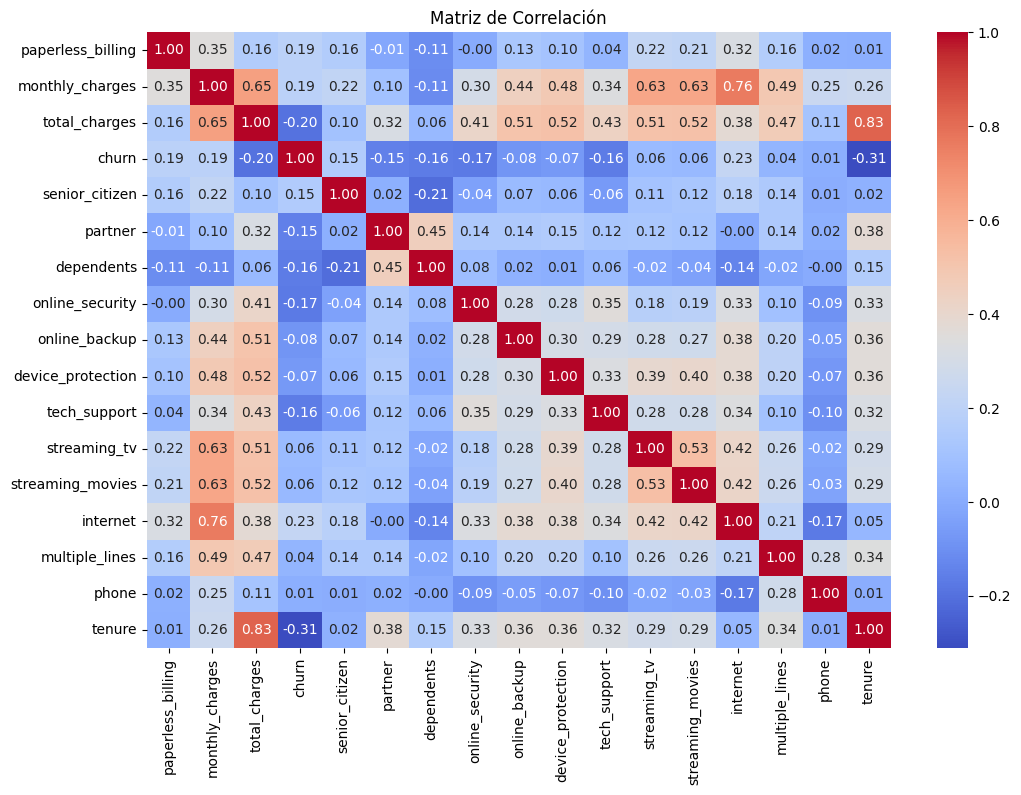

In [63]:
# Eliminar columnas que no son numéricas para matriz de correlacion
data_numeric = data_merged.select_dtypes(include=['number'])

data_numeric.drop(columns=["end_month", "end_year"], inplace=True)

# Verificar que solo quedan columnas numéricas
print(data_numeric.info())

# Crear matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

La variable tenure y total charges se encuentran altamente relacionadas segun esta grafica, eso es coherente ya que entre mas tiempo lleve un cliente en la compañia mas seran sus pagos totales, por esta razon solo usaremos tenure para obtener informacion util pero al momento del entrenamiento del modelo esta variable sera eliminada ya que le daria mas peso del que realmente tiene a la variable total_charges

#### Preparacion de datos para modelado

Ahora ya vamos a preparar los datos para poder crear el modelo, tenemos que eliminar las variables que no vamos a usar, codificar las variables si es necesario y luego realizar el train test split y tecnicas de oversampling, finalmente se reescalan las variables numericas de ser necesario.

En este punto se puede hacer una copia del df completo ya limpio para usar en el futuro en caso de ser necesario:

##### Copia de seguridad dataframes unidos y limpios

In [64]:
data_merged_backup = data_merged.copy()

##### Eliminar columnas que no se van a usar

In [65]:
data_merged.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,...,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone,end_year,end_month,tenure
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,0,0,0,0,1,0,0,NaN,NaN,1
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,Male,...,1,0,0,0,1,0,1,NaN,NaN,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,0,0,1,0,1,2019.0,12.0,4
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,1,1,0,0,1,0,0,NaN,NaN,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,0,0,1,0,1,2019.0,11.0,5


In [66]:
print(data_merged.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
internet                0
multiple_lines          0
phone                   0
end_year             5174
end_month            5174
tenure                  0
dtype: int64


aun tenemos datos nulos en algunas columnas y no vamos a usar begin_date, custom_id y las columnas con datos nulos.
Tambien eliminamos la variable tenure como se menciono en la seccion de graficas.

In [67]:
data_merged.drop(columns=["customer_id", "begin_date", "end_date", "end_month", "end_year", "tenure"], inplace=True)

In [68]:
data_merged.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone
0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,DSL,0,1,0,0,0,0,1,0,0
1,One year,0,Mailed check,56.95,1889.50,0,Male,0,0,0,DSL,1,0,1,0,0,0,1,0,1
2,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0,DSL,1,1,0,0,0,0,1,0,1
3,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0,DSL,1,0,1,1,0,0,1,0,0
4,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0,Fiber optic,0,0,0,0,0,0,1,0,1


##### Codificar variables categoricas

Para poder entrenar el modelo debemos codificar las variables categoricas y estandarizar las variables con rango numerico diferente de 1/0 del modelo

In [69]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int32  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churn              7043 non-null   int32  
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   int32  
 9   dependents         7043 non-null   int32  
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   int32  
 12  online_backup      7043 non-null   int32  
 13  device_protection  7043 non-null   int32  
 14  tech_support       7043 non-null   int32  
 15  streaming_tv       7043 non-null   int32  
 16  streaming_movies   7043 

primero vamos a codificar las variables categoricas, son estas 4:

In [70]:
print(data_merged.select_dtypes(include="object").columns)

Index(['type', 'payment_method', 'gender', 'internet_service'], dtype='object')


In [71]:
#Codificar columnas categóricas
categorical_columns = ["gender", "type", "payment_method", "internet_service"]
data_merged = pd.get_dummies(data_merged, columns=categorical_columns, drop_first=True)

In [72]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       7043 non-null   int32  
 1   monthly_charges                         7043 non-null   float64
 2   total_charges                           7043 non-null   float64
 3   churn                                   7043 non-null   int32  
 4   senior_citizen                          7043 non-null   int64  
 5   partner                                 7043 non-null   int32  
 6   dependents                              7043 non-null   int32  
 7   online_security                         7043 non-null   int32  
 8   online_backup                           7043 non-null   int32  
 9   device_protection                       7043 non-null   int32  
 10  tech_support                            7043 non-null   int3

##### Train Test Split

Vamos a separar los datos en conjuntos de entrenamiento y prueba para poder comprobar despues la efectividad del modelo.

In [73]:
#Dividimos en carateristicas y variable objetivo
X = data_merged.drop("churn", axis=1)
y = data_merged["churn"]

In [74]:
# División del dataset 70 train 15 test 15 validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Ahora pasamos con las tecnicas de sobremuestreo

##### Tecnicas de sub y sobremuestreo

En este caso se va a usar RandomOversampler

In [75]:
# Manejo del desequilibrio de clases (solo en entrenamiento)
print("Datos antes de RandomOversampler =", X_train.shape)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print("Datos despues de RandomOversampler =", X_train_resampled.shape)

Datos antes de RandomOversampler = (2112, 23)
Datos despues de RandomOversampler = (3104, 23)


##### Reescalado de variables numericas 

Por ultimo realizamos el escalado de variables numericas, en este caso, las columnas binarias (1/0) no se deben escalar ya que afectaria al modelo, por lo tanto separamos las variables que si queremos escalar que en este caso son monthly_charges y total_charges.
Esto se debe hacer para estas columnas de los tres conjuntos de datos X_train, X_test y X_val

In [76]:
cols_continuas = ["monthly_charges","total_charges"]

In [77]:
print (X_train_resampled[cols_continuas])

      monthly_charges  total_charges
0               80.05        1345.65
1              109.55        7887.25
2               20.80         635.90
3               93.75        5625.55
4               94.90        4422.95
...               ...            ...
3099            80.00        4242.35
3100            74.95         825.70
3101            85.20         627.40
3102           105.00        4026.40
3103            59.80         727.80

[3104 rows x 2 columns]


In [78]:
# 1. Seleccionar las columnas continuas del df y separarlas de las otras
df_otras_cols_train = X_train_resampled.drop(columns=cols_continuas)
df_cols_continuas_train = X_train_resampled[cols_continuas]

# 2. Escalar solo las continuas
scaler = StandardScaler()
df_cont_scaled_train = pd.DataFrame(scaler.fit_transform(df_cols_continuas_train), columns=cols_continuas, index=df_cols_continuas_train.index)

# 3. Unir de nuevo
X_train_rescaled = pd.concat([df_otras_cols_train, df_cont_scaled_train], axis=1)
print (X_train_rescaled[cols_continuas])

      monthly_charges  total_charges
0            0.457832      -0.299899
1            1.475307       2.673432
2           -1.585740      -0.622499
3            0.930354       1.645429
4            0.970018       1.098815
...               ...            ...
3099         0.456107       1.016728
3100         0.281930      -0.536230
3101         0.635459      -0.626363
3102         1.318374       0.918573
3103        -0.240604      -0.580728

[3104 rows x 2 columns]


Y hacemos lo mismo para los conjuntos de test y val

In [79]:
print (X_test[cols_continuas])

      monthly_charges  total_charges
4333            90.55        2929.75
870             98.20        7015.90
6485            73.55        4764.00
2021           108.15        6825.65
1215            80.30         250.05
...               ...            ...
3396            99.25        5846.65
5807            18.80        1094.35
2675            20.70         828.85
542             19.55          19.55
6862            88.85         372.45

[2466 rows x 2 columns]


In [80]:
# 1. Seleccionar las columnas continuas del df y separarlas de las otras
df_otras_cols_test = X_test.drop(columns=cols_continuas)
df_cols_continuas_test = X_test[cols_continuas]

# 2. Escalar solo las continuas
df_cont_scaled_test = pd.DataFrame(scaler.fit_transform(df_cols_continuas_test), columns=cols_continuas, index=df_cols_continuas_test.index)

# 3. Unir de nuevo
X_test_rescaled = pd.concat([df_otras_cols_test, df_cont_scaled_test], axis=1)
print (X_test_rescaled[cols_continuas])

      monthly_charges  total_charges
4333         0.855625       0.301475
870          1.112754       2.120305
6485         0.284226       1.117938
2021         1.447190       2.035621
1215         0.511105      -0.891315
...               ...            ...
3396         1.148046       1.599848
5807        -1.556014      -0.515499
2675        -1.492152      -0.633679
542         -1.530805      -0.993915
6862         0.798485      -0.836832

[2466 rows x 2 columns]


y por ultimo para validation

In [81]:
print (X_val[cols_continuas])

      monthly_charges  total_charges
6817            25.85        1872.20
4050            98.90        5780.70
212             19.75        1124.20
96              66.85        4748.70
4153            20.30         595.05
...               ...            ...
5830            25.35         723.30
1775           109.05        7108.20
3809            20.15         989.05
1718            19.90         323.15
2224            76.45        1233.40

[2465 rows x 2 columns]


In [82]:
# 1. Seleccionar las columnas continuas del df y separarlas de las otras
df_otras_cols_val = X_val.drop(columns=cols_continuas)
df_cols_continuas_val = X_val[cols_continuas]

# 2. Escalar solo las continuas
df_cont_scaled_val = pd.DataFrame(scaler.fit_transform(df_cols_continuas_val), columns=cols_continuas, index=df_cols_continuas_val.index)

# 3. Unir de nuevo
X_val_rescaled = pd.concat([df_otras_cols_val, df_cont_scaled_val], axis=1)
print (X_val_rescaled[cols_continuas])

      monthly_charges  total_charges
6817        -1.291798      -0.198138
4050         1.125012       1.526209
212         -1.493612      -0.528140
96           0.064659       1.070913
4153        -1.475416      -0.761590
...               ...            ...
5830        -1.308340      -0.705009
1775         1.460818       2.111874
3809        -1.480379      -0.587765
1718        -1.488650      -0.881547
2224         0.382269      -0.479963

[2465 rows x 2 columns]


Ahora ya tenemos listos nuestros datos para entrenamiento, prueba y validacion del modelo.

### Fin EDA y limpieza de datos

Por el momento eso seria todo lo que podemos hacer y concluimos aqui, hemos realizado hasta ahora los pasos 1 y 2 de nuestro plan de trabajo, a partir de aqui queda el entrenamiento de modelo, ajuste de hiperparametros y analisis de resultados y metricas, los datos ya se encuentran listos para probar algunos modelos.

Como preguntas me gustaria saber:
- ¿porque solamente se tiene fechas de salida para los meses del 10/2019 al 01/2020?

**R**: Los usuarios que no tienen fechas de salida es por que continúan con el servicio

- ¿porque hay tanta gente en la compañia que lleva alrededor de 73 meses(6 años) en la compañia?

**R**: Es normal que tengas clientes con largo tiempo de contrato

- Si se necesita algo mas para empezar con el entrenamiento de modelos.

**R**: Escoger las métricas a utilizar, accuracy, f1-score, o ROC-AUC? Cuales y por qué? (Aquí debes considerar el balance de clases)

- Si algo de lo ya hecho aqui se podria hacer de mejor forma o necesita modificarse.

## Entrenamiento del modelo

Ahora pasamos con la fase de entrenamiento del modelo, como se menciono en el plan de trabajo, los que haremos sera:

- prueba de cordura con dummy clasifier
- Entrenar varios modelos (Regresion Logistica, Random Forest, LightGBM, XGBoost) y comparar los resultados entre ellos para ver cual es mas apto para el problema en cuestion
- Dependiendo de los resultados de estos modelos podemos variar hiperparametros en los que den mejores resultados

### Prueba de Cordura

Empecemos la parte de la creacion del modelo con un modelo de verifiicacion de cordura, para poder comparar posteriormente con nuestros modelos mas avanzados:

In [83]:
# 1. Entrenamiento del DummyClassifier (estrategia: clase más frecuente)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_rescaled, y_train_resampled)

# 2. Predicción
y_pred_dummy = dummy_clf.predict(X_test_rescaled)
y_proba_dummy = dummy_clf.predict_proba(X_test_rescaled)[:, 1]  # Necesario para AUC-ROC

# 3. Métricas
accuracy = accuracy_score(y_test, y_pred_dummy)
roc_auc = roc_auc_score(y_test, y_proba_dummy)
f1 = f1_score(y_test, y_pred_dummy)

# 4. Resultados
print("=== DummyClassifier (most frequent) ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

=== DummyClassifier (most frequent) ===
Accuracy: 0.7344
AUC-ROC: 0.5000
F1 Score: 0.0000


Este modelo presenta las metricas esperadas, recordemos que este modelo se entreno con el datset "X_train_rescaled", el cual ya no se encuentra desbalanceado debido a que se uso RandomOversampler previamente en el conjunto de entrenmamiento, esto explica las metricas obtenidas.

### Entrenando varios modelos iniciales

In [84]:
# Definir modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Entrenar y evaluar modelos

results_train = {}
results_test = {}
results = {}

for name, model in models.items():
    model.fit(X_train_rescaled, y_train_resampled)
    
    y_pred_train = model.predict(X_train_rescaled)
    y_prob_train = model.predict_proba(X_train_rescaled)[:, 1]
    
    y_pred_test = model.predict(X_test_rescaled)
    y_prob_test = model.predict_proba(X_test_rescaled)[:, 1]

    y_pred = model.predict(X_val_rescaled)
    y_prob = model.predict_proba(X_val_rescaled)[:, 1]

    
    acc_train = accuracy_score(y_train_resampled, y_pred_train)
    auc_train = roc_auc_score(y_train_resampled, y_prob_train)
    #f1_train = f1_score(y_train_resampled, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_prob_test)
    #f1_test = f1_score(y_test, y_pred_test)

    acc = accuracy_score(y_val, y_pred)
    aucc = roc_auc_score(y_val, y_prob)
    #f1 = f1_score(y_val, y_prob )
    
    
    results_train[name] = {'Accuracy': acc_train, 'AUC-ROC': auc_train}
    results_test[name] = {'Accuracy': acc_test, 'AUC-ROC': auc_test}
    results[name] = {'Accuracy': acc, 'AUC-ROC': aucc}
    


# Mostrar resultados
results_train_df = pd.DataFrame(results_train).T
results_test_df = pd.DataFrame(results_test).T
results_df = pd.DataFrame(results).T


print("Resultados Train", results_train_df.sort_values(by='AUC-ROC', ascending=False))

print("Resultados Test", results_test_df.sort_values(by='AUC-ROC', ascending=False))

print("Resultados Val",results_df.sort_values(by='AUC-ROC', ascending=False))



c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1552, number of negative: 1552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 3104, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Resultados Train                      Accuracy   AUC-ROC
Random Forest        0.998711  0.999995
XGBoost              0.985825  0.999380
LightGBM             0.952964  0.991862
Logistic Regression  0.768041  0.854389
Resultados Test                      Accuracy   AUC-ROC
Logistic Regression  0.729116  0.833577
LightGBM             0.728305  0.810671
XGBoost              0.745742  0.810221
Random Forest        0.75344

En estos resultados podemos ver que para los modelos mas avanzados como Random Forest, XGBoost y LightGBM se obtienen metricas casi perfectas para el grupo de datos de entrenamiento, pero estas metricas caen bastante al tratar con los conjuntos de validacion y de testeo, podemos concluir que existe un sobreajuste severo en estos modelos.

Por otro lado el modelo de Logistic Regression no tiene metricas tan altas como los otros en el conjunto de entrenamiento, aunque sus metricas (acc = 0.768041 y AUR-ROC = 0.854780) aun podrian considerarse buenas, pero estas metricas se mantienen estables tambien en los conjuntos de prueba y entrenamiento, esto da una señal de que el modelo podria ser viable por ser mas estable.

Este modelo tambien tiene la ventaja de que requiere menos tiempo para entrenar al ser mas sencillo que los otros.

Teniendo esto en cuenta vamos a probar inicialmente un ajuste de hiperparametros con el modelo de Logistic Regression para ver si podemos obtener mejores resultados.

### Ajuste de Hiperparamemtros

Vamos a crear una funcion que nos ayude a calcular y visualizar las metricas para los conjuntos de entrenamiento, testeo y validacion para cada uno de los modelos avanzados que vamos a probar.

In [85]:
def calculate_metrics_dir(y_vector, y_pred_vector, y_proba_vector, index_name):
    results_dir ={}
    results_dir['AUC_ROC'] = roc_auc_score(y_vector, y_proba_vector)
    results_dir['Accuracy'] = accuracy_score(y_vector, y_pred_vector)
    results_dir['F1-score'] = f1_score(y_vector, y_pred_vector)
    results_dir['Recall'] = recall_score(y_vector, y_pred_vector)

    results_dir_df = pd.DataFrame([results_dir])
    results_dir_df.index = [index_name]

    return print(results_dir_df.T)

#### Logistic Regression

Veamos que resultados se obtienen al usar un GridSearch.

In [86]:
# Instancia del modelo
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

# Grid de hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_search.fit(X_train_rescaled, y_train_resampled)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor AUC-ROC (CV):", grid_search.best_score_)

# Predicciones en el conjunto de prueba
best_logreg = grid_search.best_estimator_

#train
y_pred_train_lr = best_logreg.predict(X_train_rescaled)
y_proba_train_lr = best_logreg.predict_proba(X_train_rescaled)[:, 1]

#test
y_pred_test_lr = best_logreg.predict(X_test_rescaled)
y_proba_test_lr = best_logreg.predict_proba(X_test_rescaled)[:, 1]

#val
y_pred_lr = best_logreg.predict(X_val_rescaled)
y_proba_lr = best_logreg.predict_proba(X_val_rescaled)[:, 1]

calculate_metrics_dir(y_train_resampled, y_pred_train_lr, y_proba_train_lr, "Train")
calculate_metrics_dir(y_test, y_pred_test_lr, y_proba_test_lr, "Test")
calculate_metrics_dir(y_val, y_pred_lr, y_proba_lr, "Val")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
Mejor AUC-ROC (CV): 0.850326568987958
             Train
AUC_ROC   0.853878
Accuracy  0.768041
F1-score  0.773869
Recall    0.793814
              Test
AUC_ROC   0.834801
Accuracy  0.732360
F1-score  0.618056
Recall    0.815267
               Val
AUC_ROC   0.828267
Accuracy  0.728195
F1-score  0.613164
Recall    0.811927


El tiempo de entrenamiento del modelo sigue siendo bastante bajo y eficiente.

Las metricas obtenidas son buenas y consistentes en los tres conjuntos de datos, entrenamiento, prueba y validacion. La metrica que mas cae o cambia entre estos 3 conjuntos es el F1 score, que pasa de 0.77 en entrenamiento a  0.61 en testeo y a 0.61 en validacion, este cambio aunque es significativo es de esperarse ya que en el conjunto de entrenamiento las clases se encuentran balanceadas, mientras que los conjuntos de testeo y validacion no.

veamos si podemos aumentar mas las metricas usando una busqueda mas avanzada.

In [87]:
logreg = LogisticRegression(solver='saga', max_iter=5000)

# Hiperparámetros extendidos
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 50),  # rango amplio
    'class_weight': [None, 'balanced'],
    'l1_ratio': np.linspace(0, 1, 10)  # solo aplica si elasticnet
}

# Búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_rescaled, y_train_resampled)

print("Mejores parámetros:", random_search.best_params_)
print("Mejor AUC-ROC (CV):", random_search.best_score_)

# Predicción y evaluación como antes
best_logreg = random_search.best_estimator_

#train
y_pred_train_lr_1 = best_logreg.predict(X_train_rescaled)
y_proba_train_lr_1 = best_logreg.predict_proba(X_train_rescaled)[:, 1]

#test
y_pred_test_lr_1 = best_logreg.predict(X_test_rescaled)
y_proba_test_lr_1 = best_logreg.predict_proba(X_test_rescaled)[:, 1]

#val
y_pred_lr_1 = best_logreg.predict(X_val_rescaled)
y_proba_lr_1 = best_logreg.predict_proba(X_val_rescaled)[:, 1]



calculate_metrics_dir(y_train_resampled, y_pred_train_lr_1, y_proba_train_lr_1, "Train")
calculate_metrics_dir(y_test, y_pred_test_lr_1, y_proba_test_lr_1, "Test")
calculate_metrics_dir(y_val, y_pred_lr_1, y_proba_lr_1, "Val")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'penalty': 'elasticnet', 'l1_ratio': 0.3333333333333333, 'class_weight': 'balanced', 'C': 0.18420699693267145}
Mejor AUC-ROC (CV): 0.8503958497144254
             Train
AUC_ROC   0.854176
Accuracy  0.767397
F1-score  0.773384
Recall    0.793814
              Test
AUC_ROC   0.834514
Accuracy  0.730738
F1-score  0.617952
Recall    0.819847
               Val
AUC_ROC   0.827518
Accuracy  0.725355
F1-score  0.610696
Recall    0.811927


Nuevamente el modelo presenta un comportamiento solido en los tres grupos de datos, con un AUC-ROC > 0.82 en todos los conjuntos llegando hasta 0.854 en entrenamiento.

El Recall es bastante alto tambien y estable en los tres conjuntos lo que indica que el modelo es bueno en predecir correctamente la mayoria de los clientes que se van, lo cual es clave para este estudio.

Nuvamente se ve que la metrica F1 baja en los conjuntos de testeo y validacion pero como se menciono antes esto es normal cuando existe desbalance de clases.


##### Analisis de coeficientes

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17892\2523821588.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Pyt

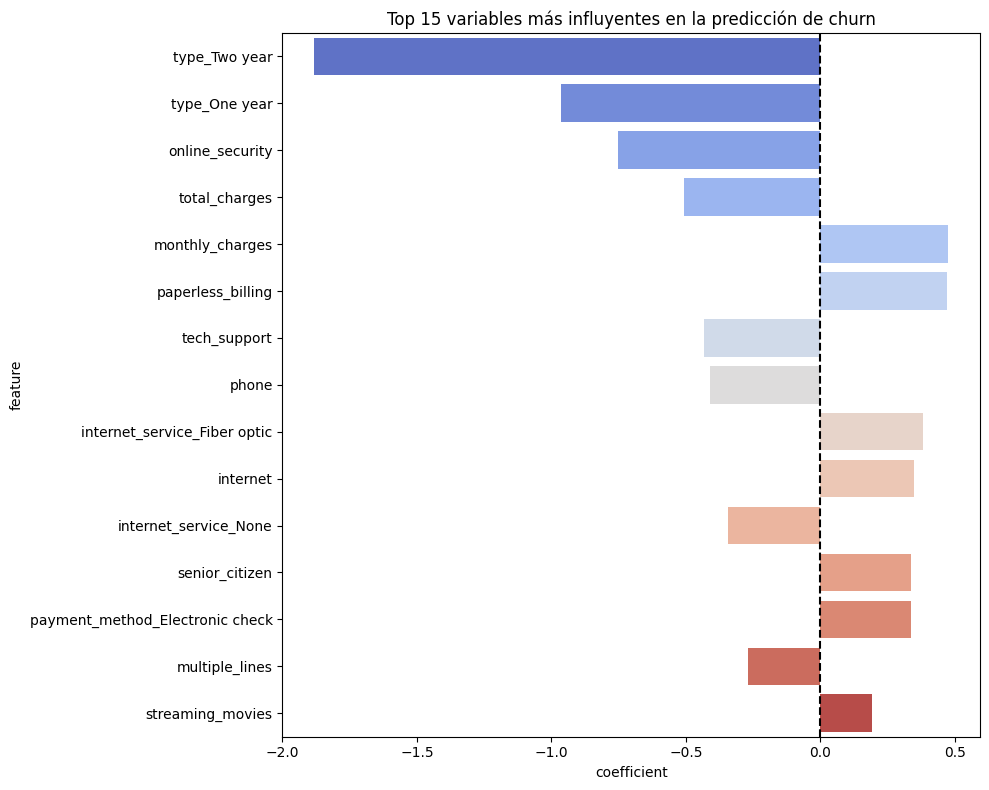

In [88]:
# Obtener los coeficientes del modelo ya entrenado
coefs = best_logreg.coef_[0]

# Asociar cada coeficiente a su variable correspondiente
coef_df = pd.DataFrame({
    'feature': X_train_rescaled.columns,
    'coefficient': coefs
})

# Ordenar por impacto absoluto (importancia)
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

# Mostrar los 15 coeficientes más relevantes
plt.figure(figsize=(10, 8))
sns.barplot(
    x='coefficient',
    y='feature',
    data=coef_df_sorted.head(15),
    palette='coolwarm',
    orient='h'
)
plt.title('Top 15 variables más influyentes en la predicción de churn')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Puedes continuar con la conclusión y análisis de los resultados
</div>

Esta grafica es muy importante y nos permite confirmar muchas de las cosas que encontramos cuando realizamos el EDA, algunas de las cosas que podemos sacar de aqui son:

- Los contratos largos de 1 o 2 años reducen fuertemente la deserción, estos son las dos variables mas influyentes positivamente, lo que quiere decir que es poco probable que una persona con contrato de 1 a 2 años deje la compañia, esto puede ser un incentivo para promover mas este tipo de contratos y asi evitar fugas.
- online_security, tech_support y phone tambien tienen un impacto positivo en la deserción, que un cliente haga uso de estos servicios puede ayudar a disminuir la deserción, se puede plantear ofrecer estos servicios con costos diferenciados para evitar fugas igual que el caso anterior.
- multiple_lines tambien tiene un impacto positivo en evitar la fuga de clientes, al parecer si el cliente tiene otras lines a su nombre como familia o segundos. telefonos puede ayudar a evitar la salida de clientes, esto se puede aprovechar con planes dobles o familiares que atraigan a mas clientes y mejoren la retencion.
- Vemos tambien a total_charges como una variable importante para en cuanto a la disminucion de churn, esto se debe a que los clientes que ya tienen mucho tiempo en la compañia tienen cargos totales mas altos, tambien se puede interpretar como que si una persona lleva ya varios años en la compañia es menos probable que se vaya.
- Como vimos en el EDA, las personas que optan por paperles billing tienden a dejar la compañia a menudo, puede deberse a una falla con este servicio o podria estar relacionado con un factor de un servicio que se percibe menos amigable por no tener el contacto humano, se puede realizar encuestas a esta parte de los clientes para ver que es lo que mas les incomoda de este feature.
- Se puede ver que hay una fuga importante cuando se trata de el servicio de internet de fibra optica, este es un factor importante que se ve respaldado por la influencia que tienen tambien las caracteristicas de internet, internet_service_None y monthly_charges, sabemos que este servicio es costoso y aumenta bastante el cargo mensual, si ademas de eso presenta intermitencia o fallas puede causar un gran impacto en la fuga de clientes. Aqui se recomienda revisar si el servicio se esta prestando correctamente, o si en realidad el problema es el costo elevado del servicio.
- El pago a traves de cheque electronico tiene un impacto en la fuga de clientes como vimos en el EDA, puede tratarse de un problema con el servicio o un problema en conjunto con los pagos mensuales, y el paperless_billing, que si estan fallando al tiempo serian muy molestos para los clientes. Se propone realizar encuestas sobre el funcionamiento de estas funciones para encontrar las fallas.
- Por ultimo mencionar tambien algo que se pudo evidenciar en el EDA y es el hecho de que los senior_clients, personas mayores si tienen de hecho un impacto en la fuga de clientes, la mayoria de ellos termina dejando la compañia, puede ser un problema respecto de los servicios que se ofrecen que son complicados de usar para estos clientes o directamente algun mal trato que se les este brindando por parte del servicio.Estos clientes representan una pequeña parte de la clientela pero una vez identificado el problema se puede pensar en hacer algun tipo de capacitacion para que estos clientes puedan usar el servicio de forma adecuada y mejorar la satisfaccion analizando costos y ganancias a futuro.  


##### Tabla acciones sugeridas

In [89]:
# === 1. Tabla de interpretación de coeficientes ===
insight_data = [
    {
        "Feature": "type_Two year y type_one year",
        "Impacto en Churn": "Muy negativo",
        "Interpretación": "Clientes con contrato de dos o un años son mucho menos propensos a cancelar.",
        "Acción sugerida": "Incentivar contratos largos con promociones."
    },
    {
        "Feature": "online_security, tech_support",
        "Impacto en Churn": "Negativo",
        "Interpretación": "Clientes con seguridad en línea cancelan menos y soporte técnico.",
        "Acción sugerida": "Promocionar servicios de seguridad y soporte como valor añadido."
    },
    {
        "Feature": "paperless_billing",
        "Impacto en Churn": "Positivo",
        "Interpretación": "La facturación sin papel puede asociarse a más cancelaciones.",
        "Acción sugerida": "Evaluar si falta de contacto humano o fallas en el servicio afectan la retención."
    },
    {
        "Feature": "payment_method_Electronic check",
        "Impacto en Churn": "Positivo",
        "Interpretación": "Este método de pago está asociado con más churn.",
        "Acción sugerida": "Fomentar métodos de pago más modernos y cómodos."
    },
    {
        "Feature": "internet_service_fiber_optic y monthly charges",
        "Impacto en Churn": "Positivo",
        "Interpretación": "Este tipo de servicio esta asociado con alta deserción probablemente por el alto costo",
        "Acción sugerida": "Revisar si se esta presentando una falla de servicio o si el problema esta relacionado con un alto costo."
    },
    {
        "Feature": "senior_citizen",
        "Impacto en Churn": "Positivo",
        "Interpretación": "La mayoria de senior_clients termina dejando la compañia",
        "Acción sugerida": "Hay que identificar si el problema es de dificultad para usar los servicios o de un mal servicio a esta parte de la clientela."
    }
]

insight_df = pd.DataFrame(insight_data)
# Mostrar el contenido completo de cada celda
print("Aclaramos que en esta tabla el impacto positivo en churn significa que este feature contribuye a la salida de clientes y el impacto negativo reduce la salida")
pd.set_option('display.max_colwidth', None)
display(insight_df)

Aclaramos que en esta tabla el impacto positivo en churn significa que este feature contribuye a la salida de clientes y el impacto negativo reduce la salida


,Feature,Impacto en Churn,Interpretación,Acción sugerida
0,type_Two year y type_one year,Muy negativo,Clientes con contrato de dos o un años son mucho menos propensos a cancelar.,Incentivar contratos largos con promociones.
1,"online_security, tech_support",Negativo,Clientes con seguridad en línea cancelan menos y soporte técnico.,Promocionar servicios de seguridad y soporte como valor añadido.
2,paperless_billing,Positivo,La facturación sin papel puede asociarse a más cancelaciones.,Evaluar si falta de contacto humano o fallas en el servicio afectan la retención.
3,payment_method_Electronic check,Positivo,Este método de pago está asociado con más churn.,Fomentar métodos de pago más modernos y cómodos.
4,internet_service_fiber_optic y monthly charges,Positivo,Este tipo de servicio esta asociado con alta deserción probablemente por el alto costo,Revisar si se esta presentando una falla de servicio o si el problema esta relacionado con un alto costo.
5,senior_citizen,Positivo,La mayoria de senior_clients termina dejando la compañia,Hay que identificar si el problema es de dificultad para usar los servicios o de un mal servicio a esta parte de la clientela.


##### Curvas Roc y Precision-Recall

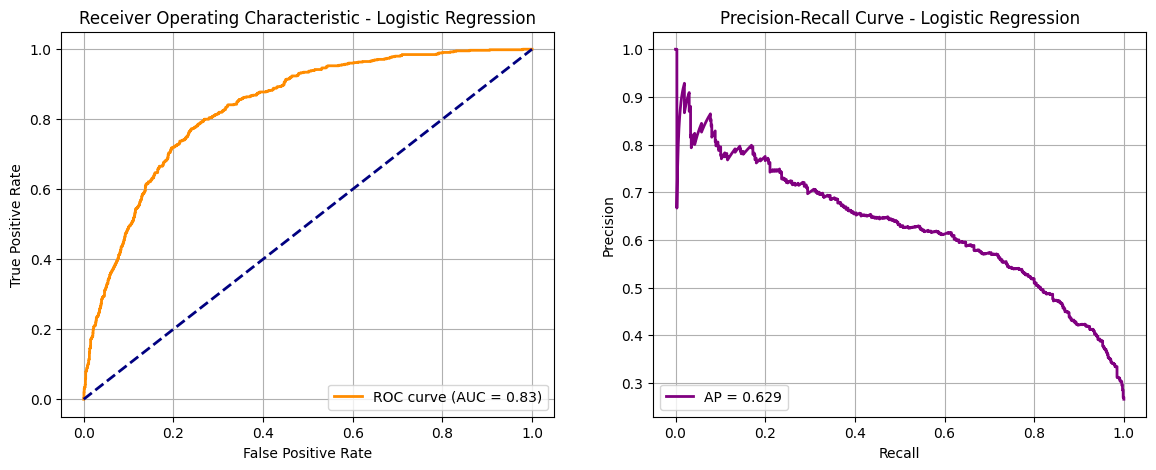

In [90]:
plt.figure(figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test_lr_1)
roc_auc = auc(fpr, tpr)



plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall Curve
prec_val, rec_val, _ = precision_recall_curve(y_test, y_proba_test_lr_1)
avg_precision = average_precision_score(y_test, y_proba_test_lr_1)

plt.subplot(1, 2, 2)
plt.plot(rec_val, prec_val, color='purple', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

La curva ROC muestra el rendimiento del modelo de regresión logística al clasificar clientes propensos a cancelar. Con un AUC de 0.83, el modelo presenta una buena capacidad de discriminación entre clientes que cancelan y los que no. La curva se aleja significativamente de la línea diagonal, lo que indica que el modelo supera ampliamente a un clasificador aleatorio. Este resultado sugiere que, en general, el modelo logra un buen equilibrio entre sensibilidad y especificidad al variar el umbral de decisión.

Por otro lado, la curva de Precisión-Recall muestra un comportamiento sólido del modelo frente al desequilibrio de clases. Se observa que la precisión se mantiene relativamente alta incluso cuando se incrementa el recall, lo que indica que el modelo es capaz de identificar correctamente una proporción considerable de los casos positivos sin generar demasiados falsos positivos. Este tipo de análisis es especialmente útil en contextos donde identificar correctamente a los clientes que abandonan es más importante que acertar en todos los casos negativos.

#### Otros modelos (LightGBM)

Probemos ahora el modelo LightGBM pero vamos a limitar un poco su alcance para evitar el sobreajuste

In [91]:
# Definir el modelo LightGBM con hiperparámetros más conservadores
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=2,
    num_leaves=31,
    reg_alpha=0.5,
    reg_lambda=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

# Entrenamiento con early stopping usando el conjunto interno de validación
lgbm.fit(
    X_train_rescaled, y_train_resampled,
    eval_set=[(X_val_rescaled, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(50)]
)

#train
y_pred_train_lg = lgbm.predict(X_train_rescaled)
y_proba_train_lg = lgbm.predict_proba(X_train_rescaled)[:, 1]

#test
y_pred_test_lg = lgbm.predict(X_test_rescaled)
y_proba_test_lg = lgbm.predict_proba(X_test_rescaled)[:, 1]

#val
y_pred_lg = lgbm.predict(X_val_rescaled)
y_proba_lg = lgbm.predict_proba(X_val_rescaled)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1552, number of negative: 1552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 3104, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [92]:
calculate_metrics_dir(y_train_resampled, y_pred_train_lg, y_proba_train_lg, "Train")
calculate_metrics_dir(y_test, y_pred_test_lg, y_proba_test_lg, "Test")
calculate_metrics_dir(y_val, y_pred_lg, y_proba_lg, "Val")

             Train
AUC_ROC   0.869731
Accuracy  0.791881
F1-score  0.805069
Recall    0.859536
              Test
AUC_ROC   0.838310
Accuracy  0.701946
F1-score  0.609250
Recall    0.874809
               Val
AUC_ROC   0.835225
Accuracy  0.691278
F1-score  0.591080
Recall    0.840979


Con las medidas tomadas este modelo ya es mucho mas viable, se ha reducido fuertemente el sobreajuste viendo un cambio mucho mas leve entre los conjuntos de entrenamiento versus testeo y validacion.

Las metricas del modelo son bastante similares al de regresion logistica que usamos antes aunque si hay una diferencia importante en la metrica de recall que incrementa aproximadamente en 5 en cada conjunto de datos, esto sugiere que este modelo es mejor identificando casos positivos aunque tambien es probable que identifique tambien mas falsos positivos, esto puede valer la pena para este tipo de estudio ya que es mas importante encontrar a los clientes que van a dejar la compañia y no es tan importante identificar un falso positivo.

##### Analisis de coeficientes

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17892\1496586616.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', palette='viridis')
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_da

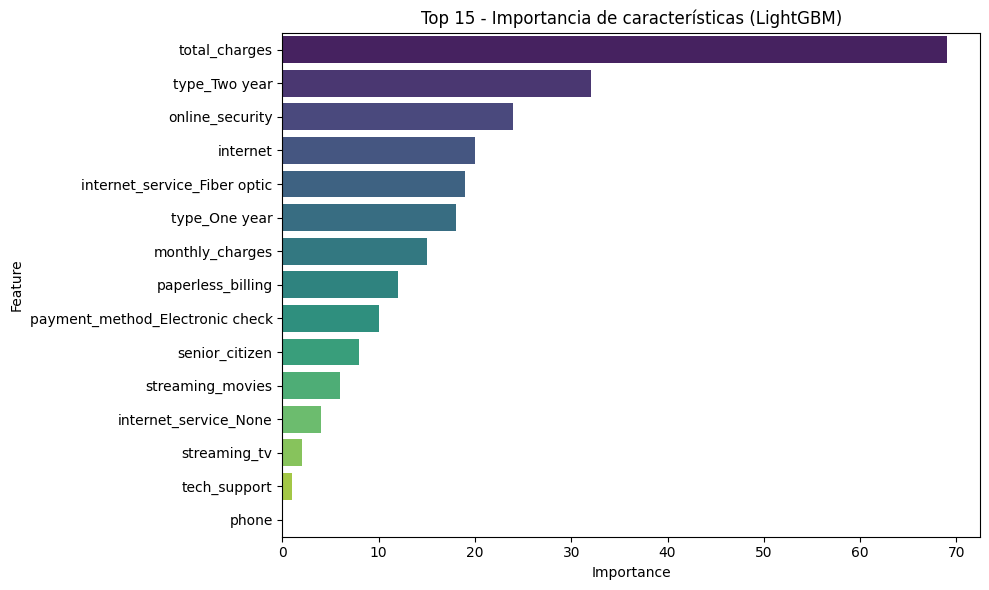

In [93]:
# Importancia de características
importances = lgbm.feature_importances_
features = X_train_rescaled.columns

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 - Importancia de características (LightGBM)')
plt.tight_layout()
plt.show()

Esta grafica es muy similar a la que se realizo en el analisis de coeficientes del modelo de regresion logistica y confirma lo que se menciono en el anterior analisis.

##### Curvas Roc y Precision-Recall

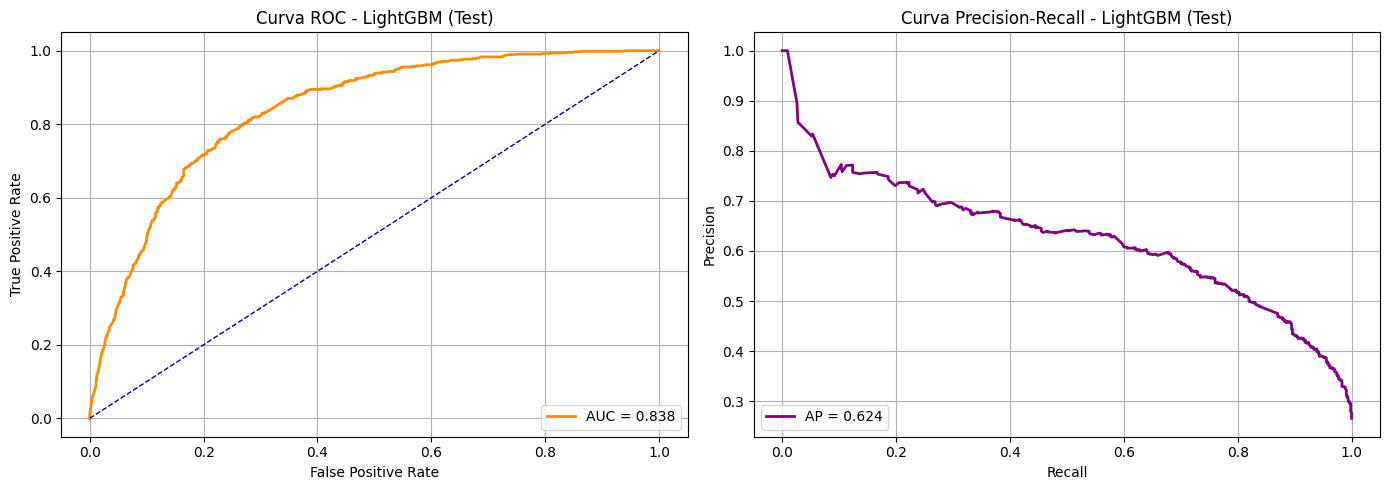

In [94]:
plt.figure(figsize=(14, 5))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_test_lg)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LightGBM (Test)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_test_lg)
avg_precision = average_precision_score(y_test, y_proba_test_lg)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - LightGBM (Test)')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()


## Conclusiones

- Se integraron varias fuentes de datos para construir una vista completa de cada cliente. 
- Se aplicó escalado y resampling para abordar el desbalance de clases, lo cual fue crucial para mejorar el desempeño predictivo, especialmente en el recall.
- Se entrenaron diferentes modelos y se comparo las metricas entre ellos, algunos modelos presentaron un fuerte sobreajuste por lo que se procedio a realizar ajuste de hiperparametros.
- Se encontro un modelo de regresion logistica con métricas sólidas y estables, y se creo una tabla de insights que habla de las caracteristicas mas importantes cuando un cliente deja la compañia y posibles acciones que se pueden realizar para obtener mas informacion o solucionar el problema.
- Tambien se realizo ajuste de hiperparametros en un modelo LightGBM que dio buenos resultados a pesar de haber estado sobreentrenado al principio, este segundo modelo entrenado presenta metricas similares a las del modelo de regresion aunque cuenta con un recall ligeramente mas alto lo que lo hace mejor para detectar casos positivos de churn, al realizar analisis de caracteristicas en este modelo se confirman los insights que se obtuvieron con el otro modelo.

In [95]:
display(insight_df)

,Feature,Impacto en Churn,Interpretación,Acción sugerida
0,type_Two year y type_one year,Muy negativo,Clientes con contrato de dos o un años son mucho menos propensos a cancelar.,Incentivar contratos largos con promociones.
1,"online_security, tech_support",Negativo,Clientes con seguridad en línea cancelan menos y soporte técnico.,Promocionar servicios de seguridad y soporte como valor añadido.
2,paperless_billing,Positivo,La facturación sin papel puede asociarse a más cancelaciones.,Evaluar si falta de contacto humano o fallas en el servicio afectan la retención.
3,payment_method_Electronic check,Positivo,Este método de pago está asociado con más churn.,Fomentar métodos de pago más modernos y cómodos.
4,internet_service_fiber_optic y monthly charges,Positivo,Este tipo de servicio esta asociado con alta deserción probablemente por el alto costo,Revisar si se esta presentando una falla de servicio o si el problema esta relacionado con un alto costo.
5,senior_citizen,Positivo,La mayoria de senior_clients termina dejando la compañia,Hay que identificar si el problema es de dificultad para usar los servicios o de un mal servicio a esta parte de la clientela.


## Informe Final de Solucion

Para finalizar se presenta el informe final de solucion respondiendo las preguntas propuestas:

Antes de responder las preguntas recordemos el objetivo del estudio "Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales.", el objetivo en si es encontrar un modelo que pueda ayudar a pronosticar cuando un cliente piensa dejar la compañia y asi poderle ofrecer codigos promocionales o planes para garantizar su permanencia en la compañia. Basicamente poder saber cuando un clinte va a dejar la compañia y porque para poder ofrecerle un plan acorde. Ahora vamos con las preguntas:

- ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

R/ Se realizaron los 4 pasos del plan estipulados al comienzo del proyecto, la experiencia ganada en proyectos previos permitio realizar un plan realista y optimizado de los se necesitaba hacer en cada seccion para obtener un modelo funcional. 

1. limpieza de datos, se llevo a cabo correctamente y sin dificultades mayores
2. Preparacion datos y analisis exploratorio, se logro hacer una limpieza correcta de los datos e ingenieria de caracteristicas para obtener modelos funcionales y confiables
3. Entrenamiento de modelos y seleccion de metricas, se entreno modelos con confiables previniendo el sobreajuste y validando con conjuntos de testeo y validacion, se escogieron metricas aptas para el estudio y se obtuvieron resultados solidos para estas
4. Conclusiones y reporte final, al final se presentan modelos confiables y utiles que se pueden emplear para solucionar el request inicial y se presentan acciones que se pueden tomar en general y para clientes en particular dependiendo de sus datos en particular.

- ¿Qué dificultades encontraste y cómo lograste resolverlas?

R/ Se presentaron dificultades en varias partes del proyecto: 

1. al momento de unir los datos en un solo dataframe se encontraron varios datos faltantes cuando se pasaba de un dataframe a otro que se solucionaron dependiendo de cada caso
2. En la seccion de preparacion de datos para el modelado se encontraron dificultades ya que al momento de codificar columnas categoricas, escalar columnas numericas y lidiar con el sobremuestreo hay algunas de estas medidas que se deben tomar antes de separar los datos en conjuntos de prueba y entrenamiento y otras medidas que se deben hacer despues de la separacion, se tuvo cuidado en esta parte para no alterar los datos de prueba y validacion y asi evitar errores.
3. En la seccion de entrenamiento de los datos al entrenar los modelos iniciales es encontro un problema de sobreajuste para varios de los modelos considerados, llegando estos a valores de 0.99 AUC-ROC para el conjunto de entrenamiento y luego callendo significativamente en los otros conjuntos de datos, este problema se soluciono usando el modelo de Logistic Regression que dio metricas bastante solidas y variando sus hiperparametros, y luego para los modelos sobrentrenados en particular LightGBM se uso tecnicas como limitar la profundidad de los arboles, aumentar los parametros de regularizacion reg_alpha y reg_lambda, tambien se incluyeron tecnicas de early stopping y validacion temprana.

- ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

R/ El analisis exploratorio de datos es muy importante en este proceso ya que brinda mucha informacion sobre los datos que despues se puede verificar y comprobar en el modelado con analisis de caracteristicas, de aqui tambien se pueden obtener bastantes insights o posibles acciones para detectar y evitar la fuga de clientes.

La correcta limpieza de los datos, unir los diferentes dataframe y preparacion para el modelado tambien fueron claves para obtener modelos de calidad y que nos permitan solucionar el problema en cuestion.

Tener en cuenta el desbalance y lidiar con el de forma correcta tambien ayuda a obtener un modelo funcional y replicable.

- ¿Cuál es tu modelo final y qué nivel de calidad tiene?

R/ al final del estuido tenemos dos modelos viables, pero el que se recomienda usar para la prediccion de fuga de clientes es el modelo LightGBM, a continuacion muestro las metricas obtenidas para este modelo en los conjuntos de entrenamiento, prueba y validacion:

In [96]:
calculate_metrics_dir(y_train_resampled, y_pred_train_lg, y_proba_train_lg, "Train Light")
calculate_metrics_dir(y_test, y_pred_test_lg, y_proba_test_lg, "Test Light")
calculate_metrics_dir(y_val, y_pred_lg, y_proba_lg, "Val Light")

          Train Light
AUC_ROC      0.869731
Accuracy     0.791881
F1-score     0.805069
Recall       0.859536
          Test Light
AUC_ROC     0.838310
Accuracy    0.701946
F1-score    0.609250
Recall      0.874809
          Val Light
AUC_ROC    0.835225
Accuracy   0.691278
F1-score   0.591080
Recall     0.840979


la calidad del modelo en el conjunto de entrenamiento se puede medir principalmente por la metrica AUC-ROC que fue la metrica principal considerada en el estudio, aqui este modelo obtuvo un 0.86 que se mantiene estable en los conjuntos de prueba y validacion mostrando que no se presenta sobreajuste, tambien hay que resaltar la metrica recall que es la razon por la que recomendamos este modelo por encima del otro (Logistic Regression) que tambien tenia metricas similares, el Recall del modelo LightGBM es superior al del otro modelo, lo que significa que a pesar de detectar un numero ligeramente mayor de falsos positivos tambien ayudara a detectar mejor los clientes que dejaran pronto la compañia por lo que es mas util para la tarea en cuestion.